#Getting Started with PySpark in Google Colab

PySpark is Python interface for Apache Spark. The primary use cases for PySpark are to work with huge amounts of data and for creating data pipelines.

You don't need to work with big data to benefit from PySpark. I find that the SparkSQL is a great tool for performing routine data anlysis. Pandas can get slow and you may find yourself writing a lot of code for data cleaning whereas the same actions take much less code in SQL. Let's get started!

See more here! http://spark.apache.org/docs/latest/api/python/

# 1. Installing PySpark in Google Colab

In [ ]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"


import findspark
findspark.init()
findspark.find()

import pyspark

from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F

spark= SparkSession \
       .builder \
       .appName("Our First Spark Example") \
       .getOrCreate()

spark

Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,373 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [5,988 kB]
Get:14 http://se

In [ ]:
spark

# 2. Reading Data

For this example, I am going to use a publicly available data set in a CSV format.

In [ ]:
import requests

file_url = "https://raw.githubusercontent.com/duonghieu7104/Trend-Analysis-Aviation-Industry-US/main/data/US%20Airline%20Flight%20Routes%20and%20Fares%201993-2024.csv"
file_name = "US Airline Flight Routes and Fares 1993-2024.csv"

print(f"Downloading data from {file_url}...")
!wget -O "{file_name}" "{file_url}"

print("Loading data with multiLine option...")

df = spark.read \
    .option("header", "true") \
    .option("multiLine", "true") \
    .option("inferSchema", "true") \
    .option("quote", '"') \
    .option("escape", '"') \
    .csv(file_name)

print(f"Data loaded successfully!")
print(f"Dataset shape: ({df.count():,} rows, {len(df.columns)} columns)")
print(f"Columns: {df.columns}")

# Show first few rows
print("\nFirst 5 rows:")
df.show(5, truncate=False)

# Show data types
print("\nData types:")
df.printSchema()

--2025-10-18 05:05:23--  https://raw.githubusercontent.com/duonghieu7104/Trend-Analysis-Aviation-Industry-US/main/data/US%20Airline%20Flight%20Routes%20and%20Fares%201993-2024.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63039765 (60M) [text/plain]
Saving to: ‘US Airline Flight Routes and Fares 1993-2024.csv’

US Airline Flight R 100%[===================>]  60.12M   328MB/s    in 0.2s    

2025-10-18 05:05:28 (328 MB/s) - ‘US Airline Flight Routes and Fares 1993-2024.csv’ saved [63039765/63039765]

Loading data with multiLine option...
Data loaded successfully!
Dataset shape: (245,955 rows, 23 columns)
Columns: ['tbl', 'Year', 'quarter', 'citymarketid_1', 'citymarketid_2', 'city1', 'city2', 'airportid_1', 'airportid_2', 'airport_1', 'airport_2', 'nsmi

In [ ]:
# XỬ LÝ GIÁ TRỊ THIẾU
print("XỬ LÝ GIÁ TRỊ THIẾU")

from pyspark.sql.functions import col as spark_col

# Drop unnecessary columns and rows with missing values
df_clean = df.drop("Geocoded_City1", "Geocoded_City2") \
    .filter(
        spark_col("carrier_lg").isNotNull() &
        spark_col("large_ms").isNotNull() &
        spark_col("fare_lg").isNotNull() &
        spark_col("carrier_low").isNotNull() &
        spark_col("lf_ms").isNotNull() &
        spark_col("fare_low").isNotNull() &
        spark_col("nsmiles").isNotNull() &
        spark_col("fare").isNotNull() &
        spark_col("passengers").isNotNull()
    )

# Summary
original_count = df.count()
clean_count = df_clean.count()
removed_count = original_count - clean_count

print(f"Original dataset: {original_count:,} rows")
print(f"Clean dataset: {clean_count:,} rows")
print(f"Removed: {removed_count:,} rows ({removed_count/original_count*100:.2f}%)")

# Update df
df = df_clean

XỬ LÝ GIÁ TRỊ THIẾU
Original dataset: 245,955 rows
Clean dataset: 244,343 rows
Removed: 1,612 rows (0.66%)


In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import numpy as np

# Chọn các biến số để phân tích tương quan
numeric_vars = ['nsmiles', 'fare', 'passengers', 'quarter', 'Year',
                'large_ms', 'lf_ms', 'fare_lg', 'fare_low']

# Tạo vector từ các biến số
assembler_corr = VectorAssembler(inputCols=numeric_vars, outputCol="features")
df_corr = assembler_corr.transform(df.select(numeric_vars)).select("features")

# Tính ma trận tương quan Pearson
correlation_matrix = Correlation.corr(df_corr, "features").collect()[0][0]
corr_array = correlation_matrix.toArray()

# Lưu kết quả để sử dụng sau
correlation_results = {}
for i, var1 in enumerate(numeric_vars):
    for j, var2 in enumerate(numeric_vars):
        correlation_results[f"{var1}__{var2}"] = corr_array[i, j]

In [ ]:
import pandas as pd

# Lấy tương quan của tất cả biến với fare
fare_idx = numeric_vars.index('fare')
correlations_with_fare = []

for i, var in enumerate(numeric_vars):
    if var != 'fare':
        corr_value = corr_array[fare_idx, i]
        correlations_with_fare.append({
            'Biến': var,
            'Tương_quan': corr_value,
            'Tương_quan_tuyệt_đối': abs(corr_value)
        })

# Chuyển sang DataFrame và sắp xếp
corr_df = pd.DataFrame(correlations_with_fare)
corr_df = corr_df.sort_values('Tương_quan_tuyệt_đối', ascending=False)

# Phân loại độ mạnh tương quan
def classify_correlation(corr):
    abs_corr = abs(corr)
    if abs_corr >= 0.7:
        return 'Rất mạnh'
    elif abs_corr >= 0.5:
        return 'Mạnh'
    elif abs_corr >= 0.3:
        return 'Trung bình'
    elif abs_corr >= 0.1:
        return 'Yếu'
    else:
        return 'Rất yếu'

corr_df['Độ_mạnh'] = corr_df['Tương_quan'].apply(classify_correlation)

# Hiển thị kết quả
print("TƯƠNG QUAN VỚI GIÁ VÉ (FARE):")
print(corr_df.to_string(index=False))

TƯƠNG QUAN VỚI GIÁ VÉ (FARE):
      Biến  Tương_quan  Tương_quan_tuyệt_đối  Độ_mạnh
   fare_lg    0.956197              0.956197 Rất mạnh
  fare_low    0.874653              0.874653 Rất mạnh
   nsmiles    0.512181              0.512181     Mạnh
     lf_ms   -0.188844              0.188844      Yếu
  large_ms   -0.182676              0.182676      Yếu
passengers   -0.174401              0.174401      Yếu
      Year    0.163892              0.163892      Yếu
   quarter   -0.026766              0.026766  Rất yếu


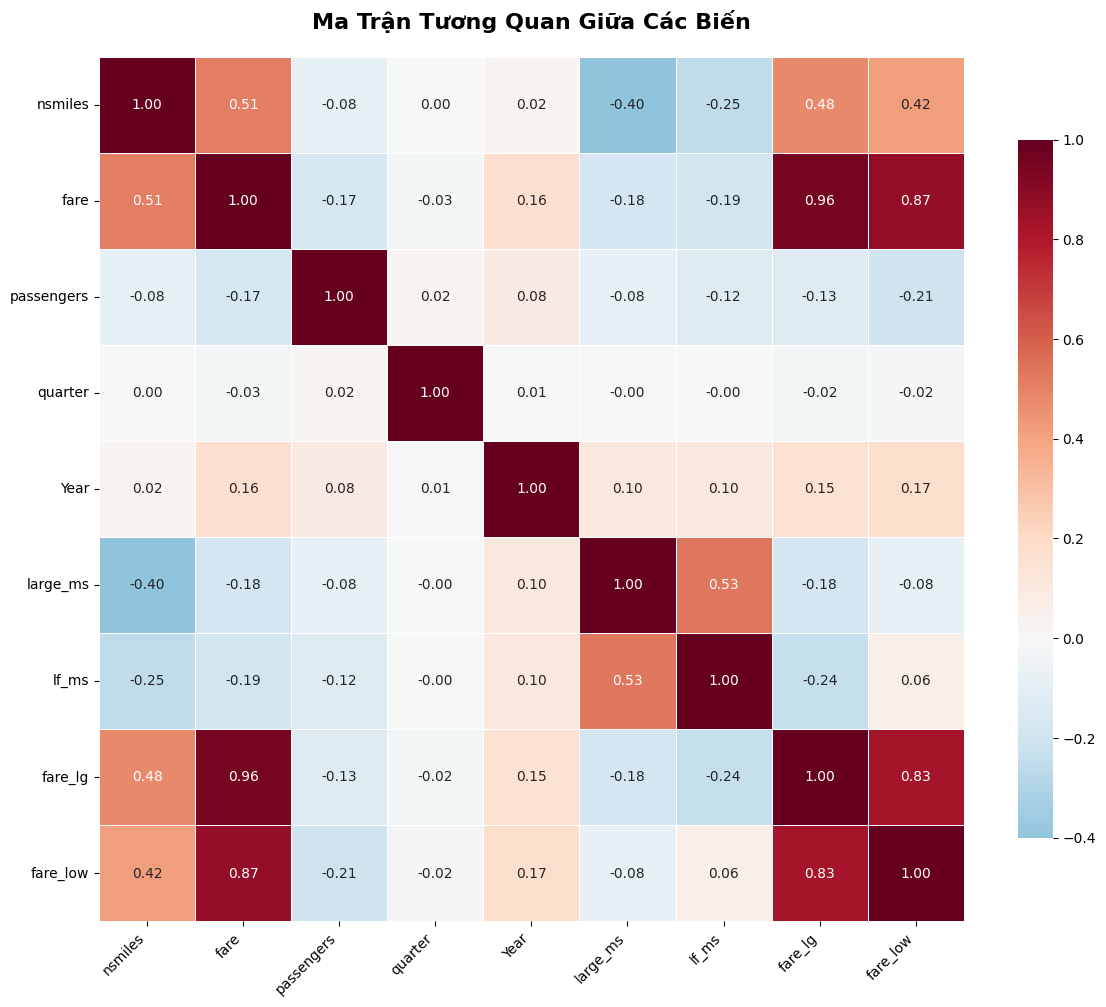

In [ ]:
# Mục đích: Trực quan hóa ma trận tương quan

import matplotlib.pyplot as plt
import seaborn as sns

# Tạo DataFrame từ ma trận tương quan
corr_matrix_df = pd.DataFrame(
    corr_array,
    columns=numeric_vars,
    index=numeric_vars
)

# Vẽ heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix_df,
    annot=True,          # Hiển thị giá trị
    fmt='.2f',           # Format 2 chữ số thập phân
    cmap='RdBu_r',       # Màu: đỏ (dương) và xanh (âm)
    center=0,            # Trung tâm tại 0
    square=True,         # Ô vuông
    linewidths=0.5,      # Đường viền
    cbar_kws={"shrink": 0.8}
)
plt.title('Ma Trận Tương Quan Giữa Các Biến', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Chọn các biến quan trọng để phân tích
key_vars = ['nsmiles', 'fare', 'passengers']

# Tính thống kê mô tả
stats_df = df.select(key_vars).describe()
stats_df.show()

# Tính thêm các thống kê bổ sung (percentiles)
from pyspark.sql.functions import expr

print("\nPHÂN VỊ (PERCENTILES):")
for var in key_vars:
    quantiles = df.approxQuantile(var, [0.25, 0.5, 0.75, 0.95, 0.99], 0.01)
    print(f"\n{var}:")
    print(f"  25%: {quantiles[0]:,.2f}")
    print(f"  50% (median): {quantiles[1]:,.2f}")
    print(f"  75%: {quantiles[2]:,.2f}")
    print(f"  95%: {quantiles[3]:,.2f}")
    print(f"  99%: {quantiles[4]:,.2f}")

+-------+------------------+------------------+-----------------+
|summary|           nsmiles|              fare|       passengers|
+-------+------------------+------------------+-----------------+
|  count|            244343|            244343|           244343|
|   mean|1189.4210556471844|218.44394040344534|301.4425582071105|
| stddev| 702.8892334240609| 79.53309940806469|512.4984522750754|
|    min|               109|              50.0|                0|
|    max|              2724|            3377.0|             8301|
+-------+------------------+------------------+-----------------+


PHÂN VỊ (PERCENTILES):

nsmiles:
  25%: 607.00
  50% (median): 1,017.00
  75%: 1,695.00
  95%: 2,510.00
  99%: 2,724.00

fare:
  25%: 162.71
  50% (median): 207.88
  75%: 261.85
  95%: 344.83
  99%: 3,377.00

passengers:
  25%: 22.00
  50% (median): 116.00
  75%: 327.00
  95%: 1,215.00
  99%: 8,301.00


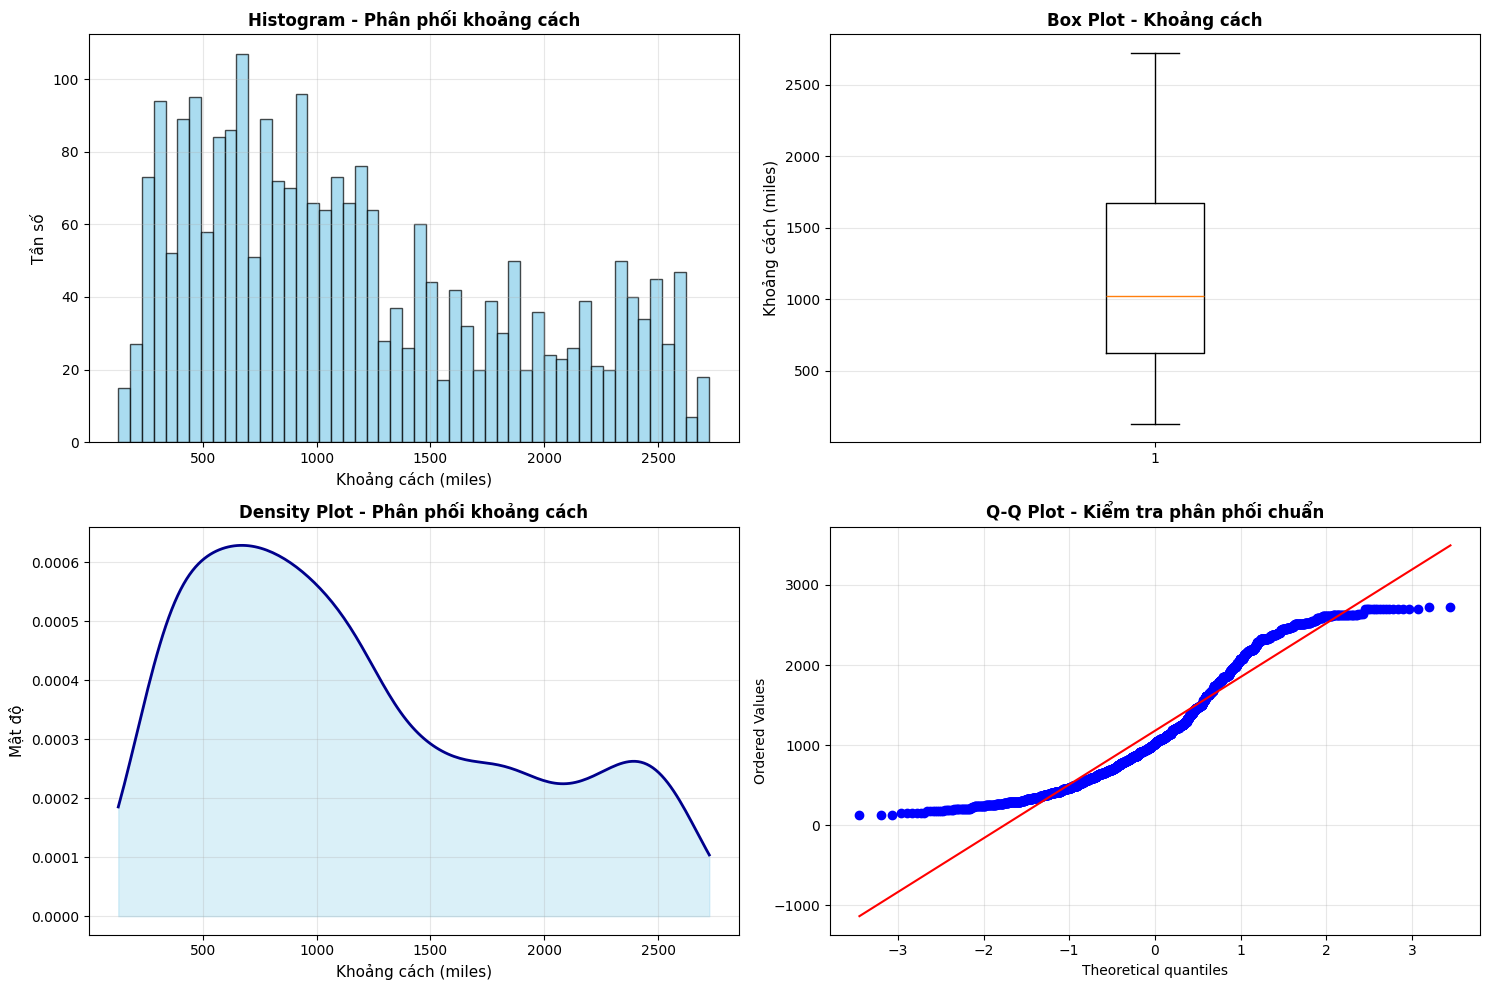

In [ ]:
# Mục đích: Hiểu phân phối của biến khoảng cách bay

# Lấy mẫu dữ liệu để vẽ (tránh quá tải)
sample_size = 0.01  # 1% dữ liệu
distance_sample = df.select('nsmiles').sample(False, sample_size, seed=42).toPandas()

# Tạo figure với nhiều subplot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Histogram
axes[0, 0].hist(distance_sample['nsmiles'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].set_xlabel('Khoảng cách (miles)', fontsize=11)
axes[0, 0].set_ylabel('Tần số', fontsize=11)
axes[0, 0].set_title('Histogram - Phân phối khoảng cách', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Box plot
axes[0, 1].boxplot(distance_sample['nsmiles'], vert=True)
axes[0, 1].set_ylabel('Khoảng cách (miles)', fontsize=11)
axes[0, 1].set_title('Box Plot - Khoảng cách', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. KDE (Kernel Density Estimation)
from scipy import stats
density = stats.gaussian_kde(distance_sample['nsmiles'])
x_range = np.linspace(distance_sample['nsmiles'].min(), distance_sample['nsmiles'].max(), 200)
axes[1, 0].plot(x_range, density(x_range), linewidth=2, color='darkblue')
axes[1, 0].fill_between(x_range, density(x_range), alpha=0.3, color='skyblue')
axes[1, 0].set_xlabel('Khoảng cách (miles)', fontsize=11)
axes[1, 0].set_ylabel('Mật độ', fontsize=11)
axes[1, 0].set_title('Density Plot - Phân phối khoảng cách', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Q-Q Plot (kiểm tra phân phối chuẩn)
stats.probplot(distance_sample['nsmiles'], dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot - Kiểm tra phân phối chuẩn', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

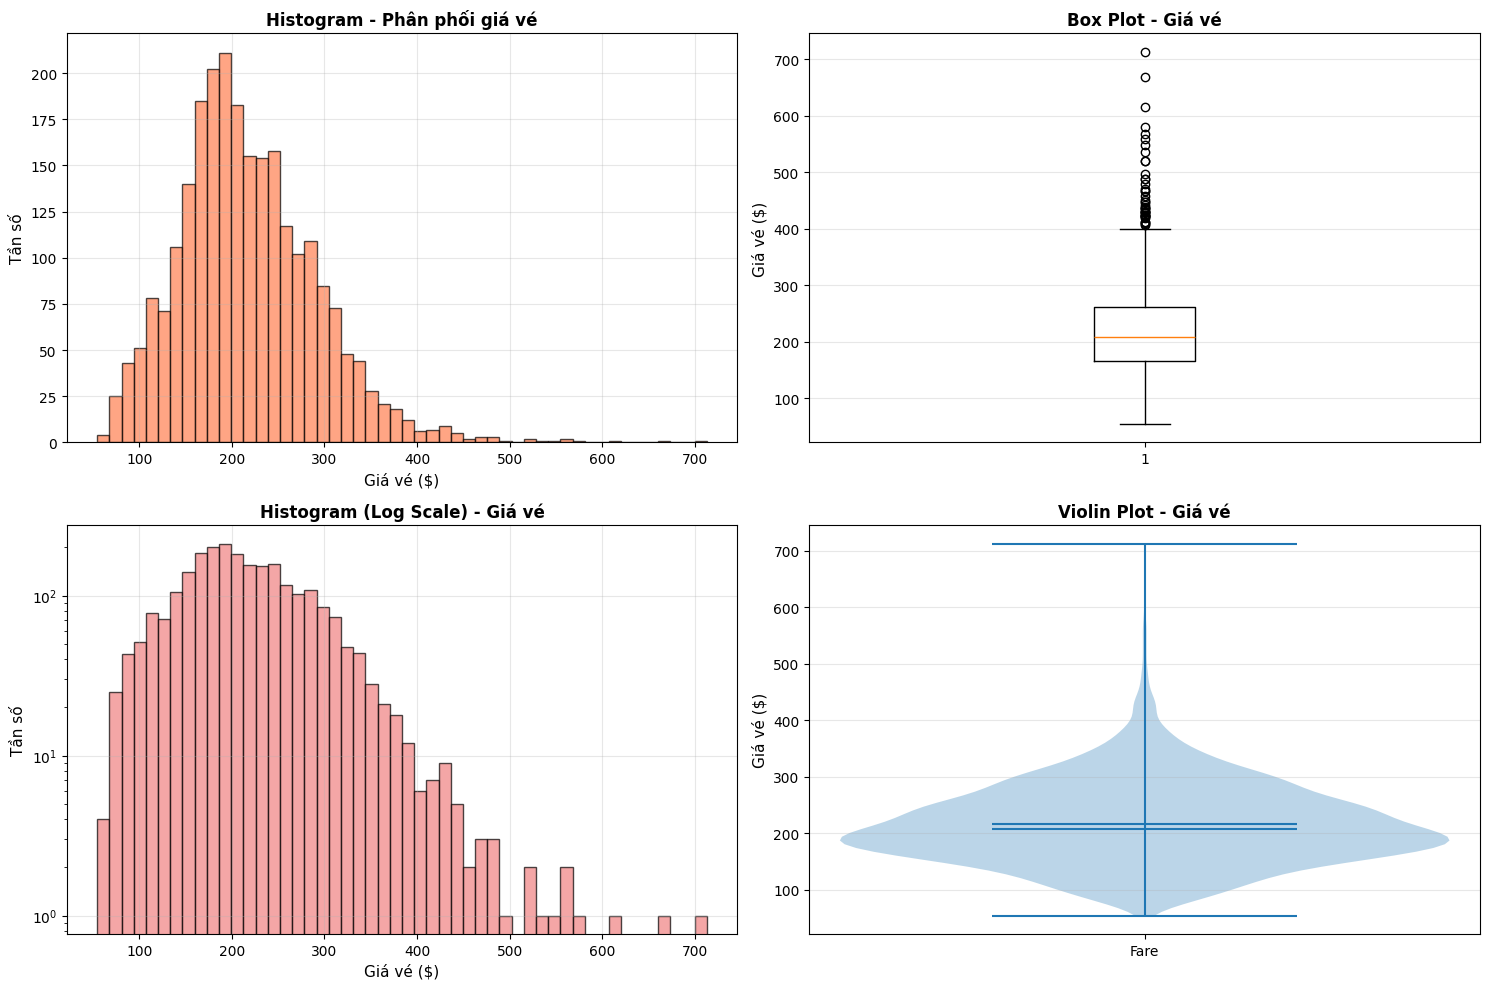

In [ ]:
# Mục đích: Hiểu phân phối của biến giá vé

# Lấy mẫu dữ liệu
fare_sample = df.select('fare').sample(False, sample_size, seed=42).toPandas()

# Tạo figure
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Histogram
axes[0, 0].hist(fare_sample['fare'], bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[0, 0].set_xlabel('Giá vé ($)', fontsize=11)
axes[0, 0].set_ylabel('Tần số', fontsize=11)
axes[0, 0].set_title('Histogram - Phân phối giá vé', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Box plot
axes[0, 1].boxplot(fare_sample['fare'], vert=True)
axes[0, 1].set_ylabel('Giá vé ($)', fontsize=11)
axes[0, 1].set_title('Box Plot - Giá vé', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Histogram với log scale (để thấy rõ các giá trị thấp)
axes[1, 0].hist(fare_sample['fare'], bins=50, edgecolor='black', alpha=0.7, color='lightcoral')
axes[1, 0].set_xlabel('Giá vé ($)', fontsize=11)
axes[1, 0].set_ylabel('Tần số', fontsize=11)
axes[1, 0].set_yscale('log')
axes[1, 0].set_title('Histogram (Log Scale) - Giá vé', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Violin plot
parts = axes[1, 1].violinplot([fare_sample['fare']], vert=True, showmeans=True, showmedians=True)
axes[1, 1].set_ylabel('Giá vé ($)', fontsize=11)
axes[1, 1].set_title('Violin Plot - Giá vé', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks([1])
axes[1, 1].set_xticklabels(['Fare'])
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

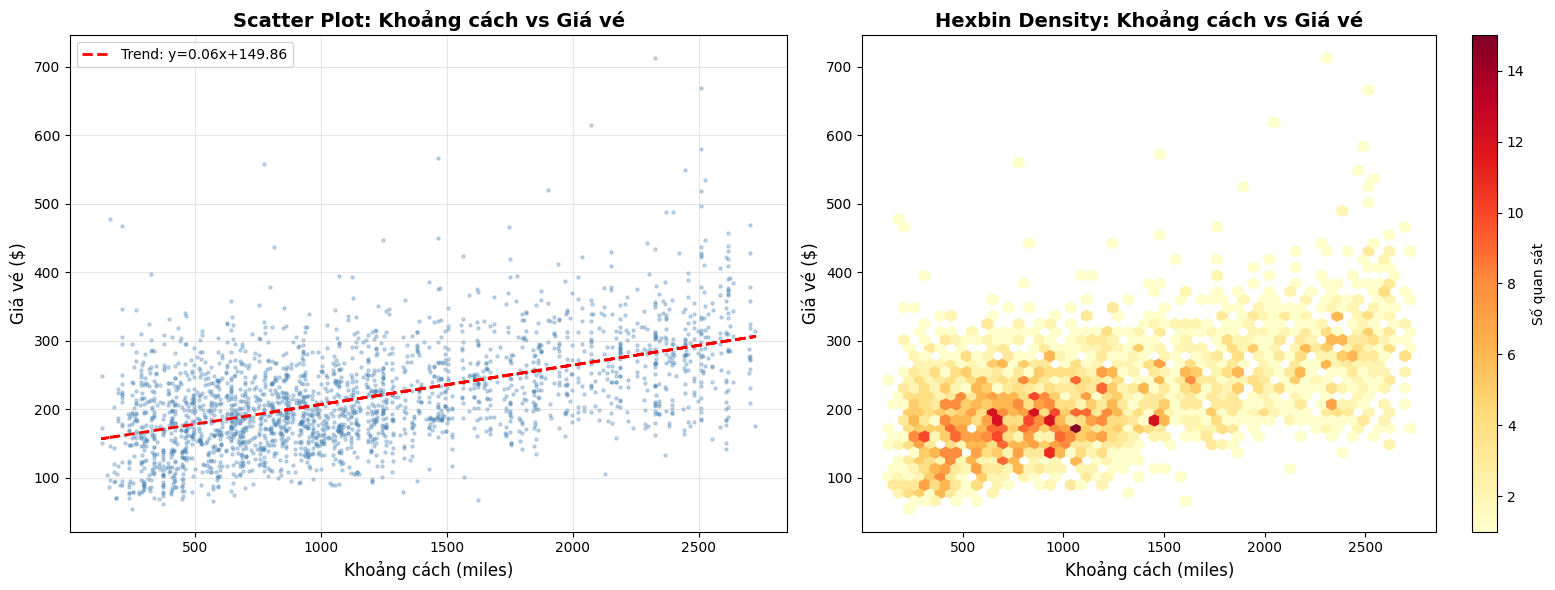


Hệ số tương quan Pearson: 0.5122


In [ ]:
# Mục đích: Trực quan hóa mối quan hệ giữa khoảng cách và giá vé

# Lấy mẫu dữ liệu
scatter_sample = df.select('nsmiles', 'fare').sample(False, sample_size, seed=42).toPandas()

# Tạo figure với 2 subplot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Scatter plot thông thường
axes[0].scatter(scatter_sample['nsmiles'], scatter_sample['fare'],
                alpha=0.3, s=5, color='steelblue')
axes[0].set_xlabel('Khoảng cách (miles)', fontsize=12)
axes[0].set_ylabel('Giá vé ($)', fontsize=12)
axes[0].set_title('Scatter Plot: Khoảng cách vs Giá vé', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Thêm đường xu hướng (trend line)
z = np.polyfit(scatter_sample['nsmiles'], scatter_sample['fare'], 1)
p = np.poly1d(z)
axes[0].plot(scatter_sample['nsmiles'], p(scatter_sample['nsmiles']),
             "r--", linewidth=2, label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')
axes[0].legend(fontsize=10)

# 2. Hexbin plot (tốt hơn cho nhiều điểm)
hb = axes[1].hexbin(scatter_sample['nsmiles'], scatter_sample['fare'],
                     gridsize=50, cmap='YlOrRd', mincnt=1)
axes[1].set_xlabel('Khoảng cách (miles)', fontsize=12)
axes[1].set_ylabel('Giá vé ($)', fontsize=12)
axes[1].set_title('Hexbin Density: Khoảng cách vs Giá vé', fontsize=14, fontweight='bold')
cb = plt.colorbar(hb, ax=axes[1])
cb.set_label('Số quan sát', fontsize=10)

plt.tight_layout()
plt.show()

# In tương quan
corr_distance_fare = df.stat.corr("nsmiles", "fare")
print(f"\nHệ số tương quan Pearson: {corr_distance_fare:.4f}")

/tmp/ipython-input-3840824665.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=boxplot_data, x='nhom_khoang_cach', y='fare',
/tmp/ipython-input-3840824665.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=boxplot_data, x='nhom_khoang_cach', y='fare',


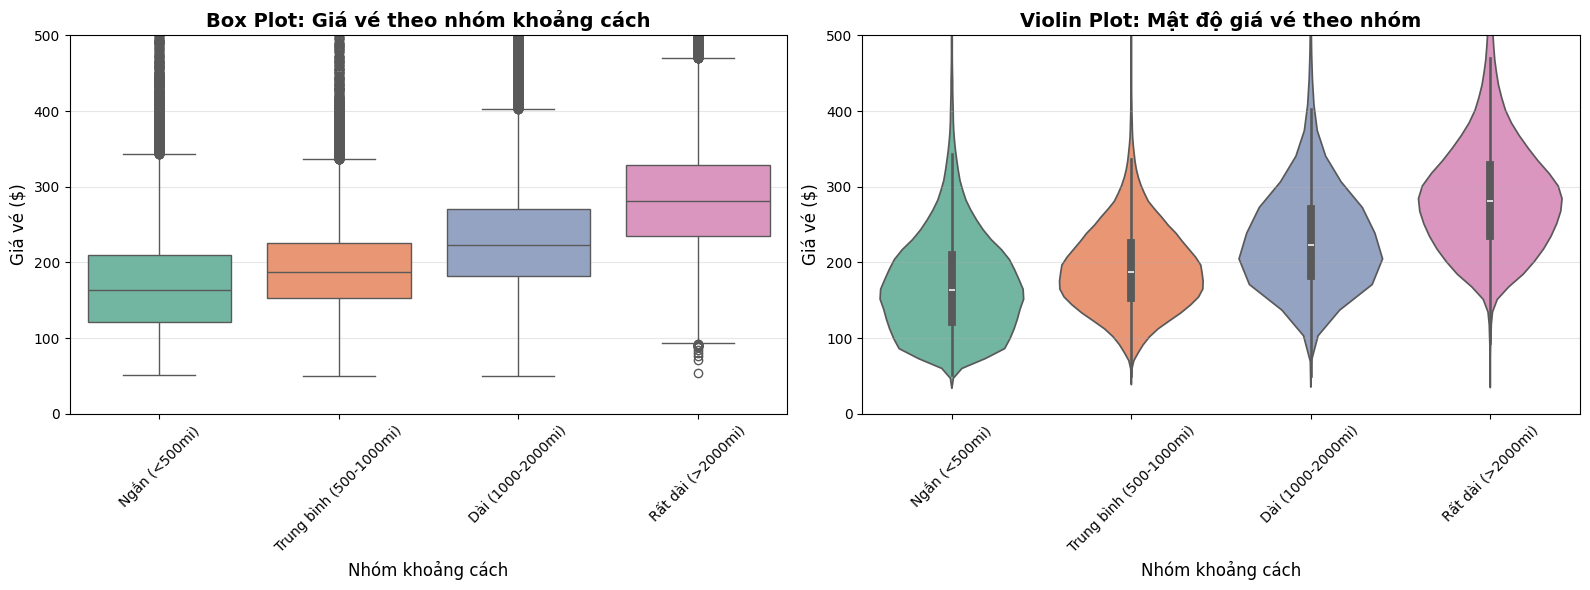


THỐNG KÊ GIÁ VÉ THEO NHÓM KHOẢNG CÁCH:
+--------------------+--------+------------------+-------------+------------+
|    nhom_khoang_cach|so_luong|    gia_trung_binh|gia_thap_nhat|gia_cao_nhat|
+--------------------+--------+------------------+-------------+------------+
|   Dài (1000-2000mi)|   81735| 230.7397242307457|         50.0|      3377.0|
|       Ngắn (<500mi)|   45116|172.04356481070997|         50.5|      1312.0|
|   Rất dài (>2000mi)|   43478|288.28362229173473|         53.5|      1664.0|
|Trung bình (500-1...|   74014|192.12343029697203|         50.4|      1069.0|
+--------------------+--------+------------------+-------------+------------+



In [ ]:
# Mục đích: So sánh giá vé giữa các nhóm khoảng cách khác nhau

# Tạo nhóm khoảng cách
from pyspark.sql.functions import when, col, count, avg, min, max

df_grouped = df.withColumn('nhom_khoang_cach',
    when(col('nsmiles') < 500, 'Ngắn (<500mi)')
    .when((col('nsmiles') >= 500) & (col('nsmiles') < 1000), 'Trung bình (500-1000mi)')
    .when((col('nsmiles') >= 1000) & (col('nsmiles') < 2000), 'Dài (1000-2000mi)')
    .otherwise('Rất dài (>2000mi)')
)

# Chuyển sang Pandas để vẽ
boxplot_data = df_grouped.select('nhom_khoang_cach', 'fare').toPandas()

# Tạo figure với 2 subplot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Box plot
order = ['Ngắn (<500mi)', 'Trung bình (500-1000mi)', 'Dài (1000-2000mi)', 'Rất dài (>2000mi)']
sns.boxplot(data=boxplot_data, x='nhom_khoang_cach', y='fare',
            order=order, ax=axes[0], palette='Set2')
axes[0].set_xlabel('Nhóm khoảng cách', fontsize=12)
axes[0].set_ylabel('Giá vé ($)', fontsize=12)
axes[0].set_title('Box Plot: Giá vé theo nhóm khoảng cách', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylim(0, 500)  # Giới hạn để loại outliers
axes[0].grid(True, alpha=0.3, axis='y')

# 2. Violin plot
sns.violinplot(data=boxplot_data, x='nhom_khoang_cach', y='fare',
               order=order, ax=axes[1], palette='Set2')
axes[1].set_xlabel('Nhóm khoảng cách', fontsize=12)
axes[1].set_ylabel('Giá vé ($)', fontsize=12)
axes[1].set_title('Violin Plot: Mật độ giá vé theo nhóm', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_ylim(0, 500)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Thống kê theo nhóm
print("\nTHỐNG KÊ GIÁ VÉ THEO NHÓM KHOẢNG CÁCH:")
df_grouped.groupBy('nhom_khoang_cach').agg(
    count('fare').alias('so_luong'),
    avg('fare').alias('gia_trung_binh'),
    min('fare').alias('gia_thap_nhat'),
    max('fare').alias('gia_cao_nhat')
).orderBy('nhom_khoang_cach').show()

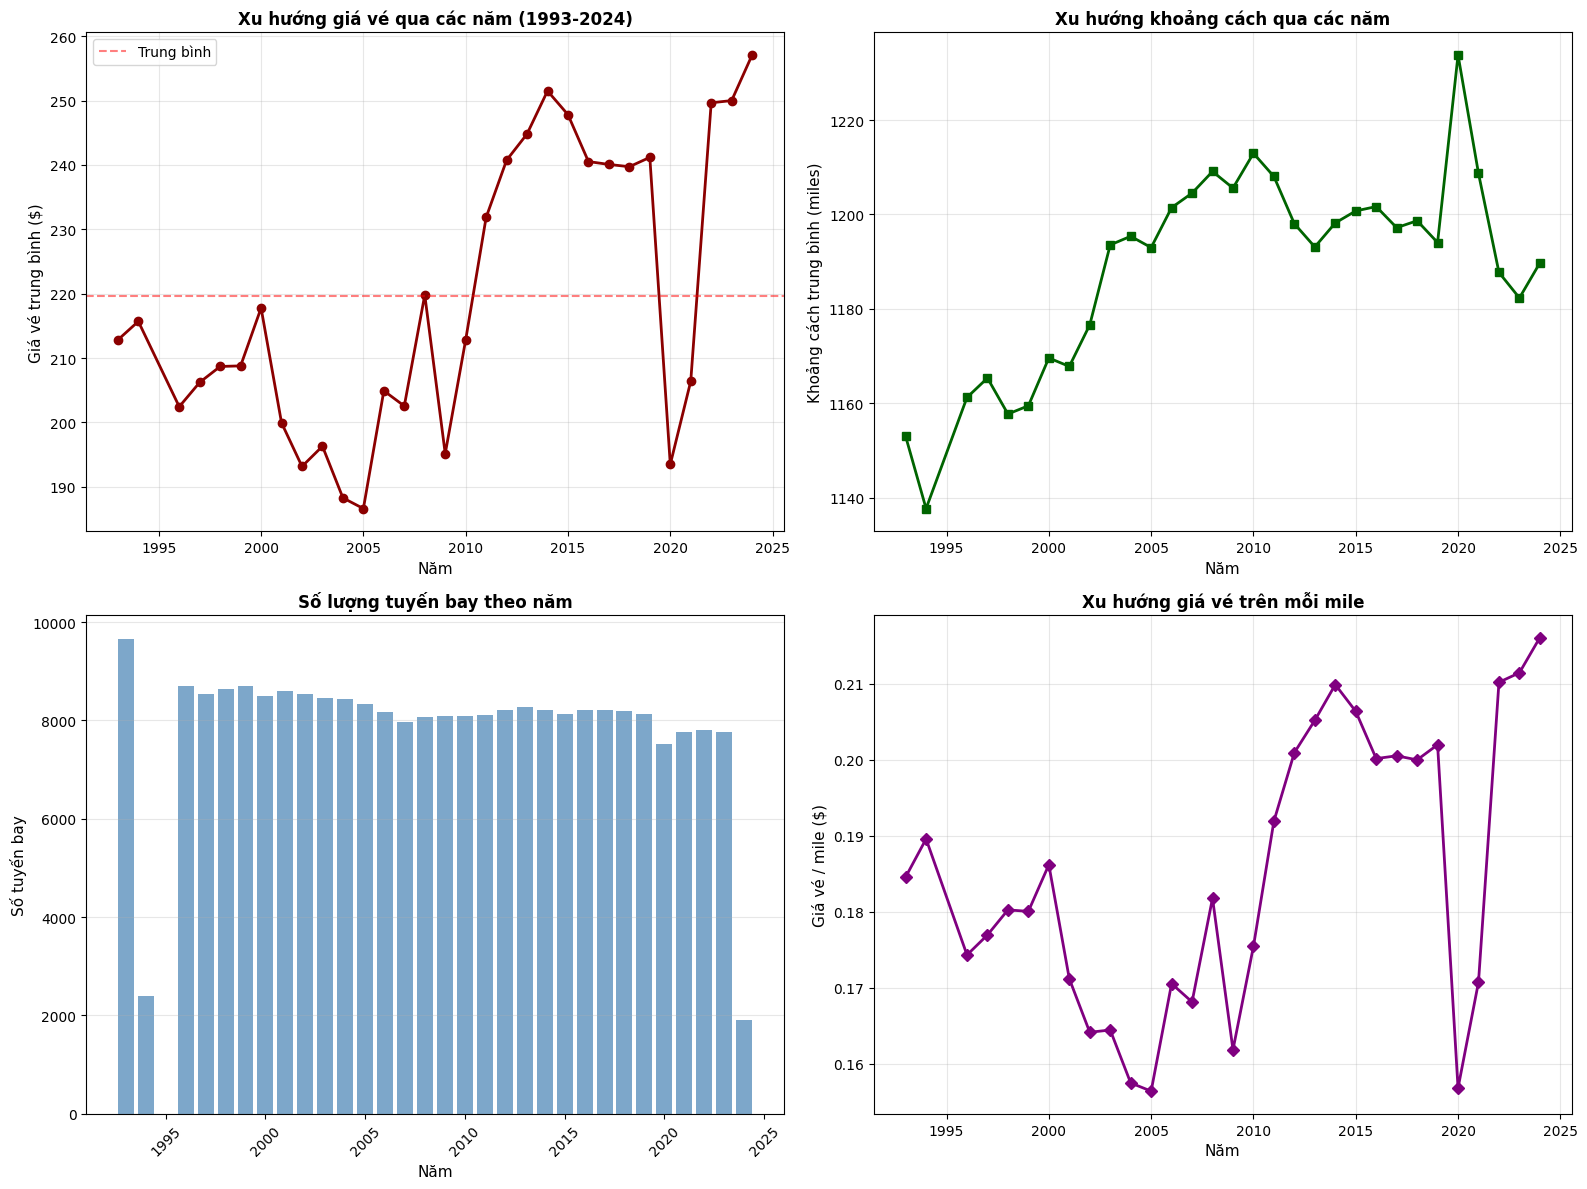

In [ ]:
# Tính trung bình theo năm
yearly_stats = df.groupBy('Year').agg(
    avg('fare').alias('gia_trung_binh'),
    avg('nsmiles').alias('khoang_cach_trung_binh'),
    avg('passengers').alias('hanh_khach_trung_binh'),
    count('*').alias('so_chuyen')
).orderBy('Year').toPandas()

# Tạo figure với 4 subplot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Giá vé trung bình theo năm
axes[0, 0].plot(yearly_stats['Year'], yearly_stats['gia_trung_binh'],
                marker='o', linewidth=2, markersize=6, color='darkred')
axes[0, 0].set_xlabel('Năm', fontsize=11)
axes[0, 0].set_ylabel('Giá vé trung bình ($)', fontsize=11)
axes[0, 0].set_title('Xu hướng giá vé qua các năm (1993-2024)', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(y=yearly_stats['gia_trung_binh'].mean(),
                    color='r', linestyle='--', alpha=0.5, label='Trung bình')
axes[0, 0].legend()

# 2. Khoảng cách trung bình theo năm
axes[0, 1].plot(yearly_stats['Year'], yearly_stats['khoang_cach_trung_binh'],
                marker='s', linewidth=2, markersize=6, color='darkgreen')
axes[0, 1].set_xlabel('Năm', fontsize=11)
axes[0, 1].set_ylabel('Khoảng cách trung bình (miles)', fontsize=11)
axes[0, 1].set_title('Xu hướng khoảng cách qua các năm', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Số chuyến bay theo năm
axes[1, 0].bar(yearly_stats['Year'], yearly_stats['so_chuyen'],
               color='steelblue', alpha=0.7)
axes[1, 0].set_xlabel('Năm', fontsize=11)
axes[1, 0].set_ylabel('Số tuyến bay', fontsize=11)
axes[1, 0].set_title('Số lượng tuyến bay theo năm', fontsize=12, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Giá vé trên mỗi mile
yearly_stats['gia_per_mile'] = yearly_stats['gia_trung_binh'] / yearly_stats['khoang_cach_trung_binh']
axes[1, 1].plot(yearly_stats['Year'], yearly_stats['gia_per_mile'],
                marker='D', linewidth=2, markersize=6, color='purple')
axes[1, 1].set_xlabel('Năm', fontsize=11)
axes[1, 1].set_ylabel('Giá vé / mile ($)', fontsize=11)
axes[1, 1].set_title('Xu hướng giá vé trên mỗi mile', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

/tmp/ipython-input-3486366275.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=quarterly_data, x='ten_quy', y='fare',


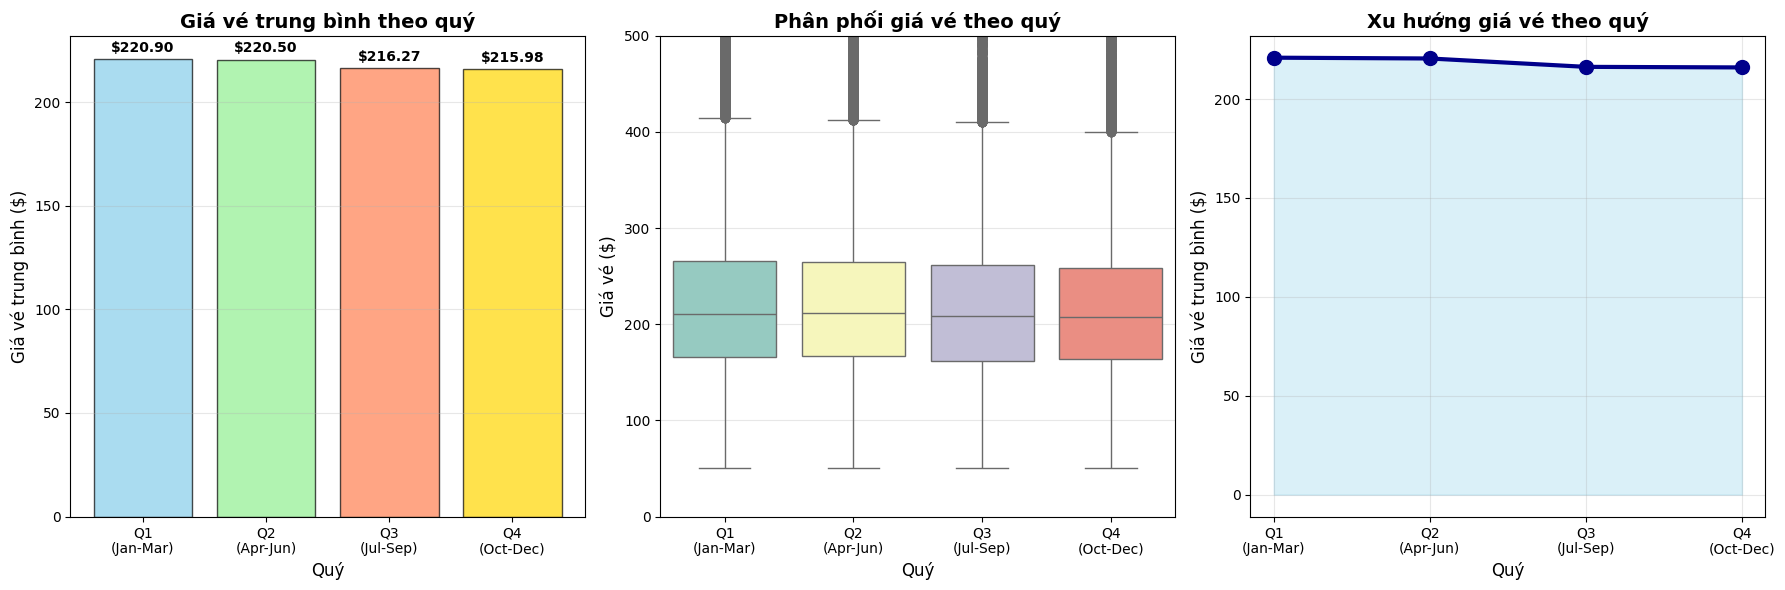


THỐNG KÊ THEO QUÝ:
 quarter  gia_trung_binh  so_luong  gia_min  gia_max       ten_quy
       1      220.904761     63477    50.40  1161.22 Q1\n(Jan-Mar)
       2      220.498615     60181    50.00  1470.40 Q2\n(Apr-Jun)
       3      216.269382     60830    50.98  3377.00 Q3\n(Jul-Sep)
       4      215.978324     59855    50.50  1664.00 Q4\n(Oct-Dec)


In [ ]:
# Mục đích: Kiểm tra ảnh hưởng của mùa vụ (quý) lên giá vé

# Tính thống kê theo quý
quarterly_stats = df.groupBy('quarter').agg(
    avg('fare').alias('gia_trung_binh'),
    count('*').alias('so_luong'),
    min('fare').alias('gia_min'),
    max('fare').alias('gia_max')
).orderBy('quarter').toPandas()

# Đặt tên quý
quarter_names = {1: 'Q1\n(Jan-Mar)', 2: 'Q2\n(Apr-Jun)',
                 3: 'Q3\n(Jul-Sep)', 4: 'Q4\n(Oct-Dec)'}
quarterly_stats['ten_quy'] = quarterly_stats['quarter'].map(quarter_names)

# Lấy dữ liệu để vẽ boxplot
quarterly_data = df.select('quarter', 'fare').toPandas()
quarterly_data['ten_quy'] = quarterly_data['quarter'].map(quarter_names)

# Tạo figure với 3 subplot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Bar chart - Giá trung bình theo quý
axes[0].bar(quarterly_stats['ten_quy'], quarterly_stats['gia_trung_binh'],
            color=['skyblue', 'lightgreen', 'coral', 'gold'], alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Quý', fontsize=12)
axes[0].set_ylabel('Giá vé trung bình ($)', fontsize=12)
axes[0].set_title('Giá vé trung bình theo quý', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
# Thêm giá trị lên cột
for i, v in enumerate(quarterly_stats['gia_trung_binh']):
    axes[0].text(i, v + 2, f'${v:.2f}', ha='center', va='bottom', fontweight='bold')

# 2. Box plot - Phân phối theo quý
order = [quarter_names[i] for i in range(1, 5)]
sns.boxplot(data=quarterly_data, x='ten_quy', y='fare',
            order=order, ax=axes[1], palette='Set3')
axes[1].set_xlabel('Quý', fontsize=12)
axes[1].set_ylabel('Giá vé ($)', fontsize=12)
axes[1].set_title('Phân phối giá vé theo quý', fontsize=14, fontweight='bold')
axes[1].set_ylim(0, 500)
axes[1].grid(True, alpha=0.3, axis='y')

# 3. Line chart - Xu hướng qua các quý
axes[2].plot(quarterly_stats['ten_quy'], quarterly_stats['gia_trung_binh'],
             marker='o', linewidth=3, markersize=10, color='darkblue')
axes[2].fill_between(range(len(quarterly_stats)), quarterly_stats['gia_trung_binh'],
                      alpha=0.3, color='skyblue')
axes[2].set_xlabel('Quý', fontsize=12)
axes[2].set_ylabel('Giá vé trung bình ($)', fontsize=12)
axes[2].set_title('Xu hướng giá vé theo quý', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# In bảng thống kê
print("\nTHỐNG KÊ THEO QUÝ:")
print(quarterly_stats.to_string(index=False))

In [ ]:
quantiles = df.approxQuantile('fare', [0.5, 0.75, 0.90, 0.95, 0.99, 0.999], 0.01)
print("Phân vị giá vé:")
print(f"  50% (Median):  ${quantiles[0]:,.2f}")
print(f"  75%:           ${quantiles[1]:,.2f}")
print(f"  90%:           ${quantiles[2]:,.2f}")
print(f"  95%:           ${quantiles[3]:,.2f}")
print(f"  99%:           ${quantiles[4]:,.2f}")
print(f"  99.9%:         ${quantiles[5]:,.2f}")

# Bước 2: Đếm số outliers
outliers_1000 = df.filter(col('fare') > 1000).count()
outliers_500 = df.filter(col('fare') > 500).count()
total = df.count()

print(f"\nSố lượng giá vé cao:")
print(f"  > $500:  {outliers_500:,} ({outliers_500/total*100:.2f}%)")
print(f"  > $1000: {outliers_1000:,} ({outliers_1000/total*100:.2f}%)")

# Bước 3: Xem chi tiết những vé đắt
print("\n10 vé ĐẮT NHẤT:")
df.orderBy(col('fare').desc()).select(
    'fare', 'nsmiles', 'city1', 'city2', 'passengers', 'Year', 'quarter'
).show(10, truncate=False)

# Bước 4: Pattern recognition
expensive = df.filter(col('fare') > 1000)
print("\nĐẶC ĐIỂM CỦA VÉ ĐẮT:")
expensive.select('nsmiles', 'passengers', 'quarter', 'Year').describe().show()

Phân vị giá vé:
  50% (Median):  $207.88
  75%:           $261.85
  90%:           $312.29
  95%:           $344.83
  99%:           $3,377.00
  99.9%:         $3,377.00

Số lượng giá vé cao:
  > $500:  1,244 (0.51%)
  > $1000: 37 (0.02%)

10 vé ĐẮT NHẤT:
+-------+-------+-------------------------------------+-------------------------------------+----------+----+-------+
|fare   |nsmiles|city1                                |city2                                |passengers|Year|quarter|
+-------+-------+-------------------------------------+-------------------------------------+----------+----+-------+
|3377.0 |1751   |Chicago, IL                          |Portland, OR                         |0         |2001|3      |
|1664.0 |2371   |Los Angeles, CA (Metropolitan Area)  |Norfolk, VA (Metropolitan Area)      |0         |2021|4      |
|1470.4 |1659   |Denver, CO                           |New York City, NY (Metropolitan Area)|0         |1997|2      |
|1420.6 |1071   |Des Moines, IA     

--> Suy ra nên bỏ outline này

In [ ]:
print("XỬ LÝ LỖI DỮ LIỆU - LOẠI BỎ VÉ KHÔNG CÓ HÀNH KHÁCH")

# Đếm số vé có passengers = 0
zero_pax = df.filter(col('passengers') == 0).count()
total = df.count()

print(f"\n1. PHÂN TÍCH:")
print(f"  Vé có passengers = 0: {zero_pax:,} ({zero_pax/total*100:.2f}%)")

# Xem phân phối giá của những vé này
print("\n2. PHÂN PHỐI GIÁ CỦA VÉ CÓ PASSENGERS = 0:")
df.filter(col('passengers') == 0).select('fare').describe().show()

print("\n3. QUYẾT ĐỊNH:")
print("  ✅ LOẠI BỎ tất cả vé có passengers = 0")
print("  LÝ DO:")
print("    • Không logic: vé không thể có giá nếu không có hành khách")
print("    • Chứa các outliers giá vé cao bất thường")
print("    • Dữ liệu không đáng tin cậy")

# Loại bỏ
df = df.filter(col('passengers') > 0)

print(f"\n4. KẾT QUẢ:")
print(f"  Đã loại bỏ: {zero_pax:,} dòng")
print(f"  Còn lại: {df.count():,} dòng")

# Kiểm tra lại giá vé cao nhất
max_fare = df.agg(max('fare')).collect()[0][0]
print(f"  Giá vé cao nhất sau xử lý: ${max_fare:,.2f}")

XỬ LÝ LỖI DỮ LIỆU - LOẠI BỎ VÉ KHÔNG CÓ HÀNH KHÁCH

1. PHÂN TÍCH:
  Vé có passengers = 0: 0 (0.00%)

2. PHÂN PHỐI GIÁ CỦA VÉ CÓ PASSENGERS = 0:
+-------+----+
|summary|fare|
+-------+----+
|  count|   0|
|   mean|NULL|
| stddev|NULL|
|    min|NULL|
|    max|NULL|
+-------+----+


3. QUYẾT ĐỊNH:
  ✅ LOẠI BỎ tất cả vé có passengers = 0
  LÝ DO:
    • Không logic: vé không thể có giá nếu không có hành khách
    • Chứa các outliers giá vé cao bất thường
    • Dữ liệu không đáng tin cậy

4. KẾT QUẢ:
  Đã loại bỏ: 0 dòng
  Còn lại: 237,985 dòng
  Giá vé cao nhất sau xử lý: $1,161.22


In [ ]:
# Mục đích: Tạo train/test split và feature vectors

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

# Chia dữ liệu thành train (80%) và test (20%)
# Sử dụng seed để reproducible
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

print(f"Dữ liệu training: {train_data.count():,} dòng ({train_data.count()/df.count()*100:.1f}%)")
print(f"Dữ liệu testing:  {test_data.count():,} dòng ({test_data.count()/df.count()*100:.1f}%)")

# Cache để tăng tốc
train_data.cache()
test_data.cache()

Dữ liệu training: 190,123 dòng (79.9%)
Dữ liệu testing:  47,862 dòng (20.1%)


DataFrame[tbl: string, Year: int, quarter: int, citymarketid_1: int, citymarketid_2: int, city1: string, city2: string, airportid_1: int, airportid_2: int, airport_1: string, airport_2: string, nsmiles: int, passengers: int, fare: double, carrier_lg: string, large_ms: double, fare_lg: double, carrier_low: string, lf_ms: double, fare_low: double, tbl1apk: string]

In [ ]:
# Mục đích: Baseline model - dự đoán giá vé dựa trên khoảng cách

# Bước 1: Tạo feature vector từ khoảng cách
assembler_simple = VectorAssembler(
    inputCols=['nsmiles'],
    outputCol='features',
    handleInvalid='skip'  # Bỏ qua missing values
)

# Bước 2: Chuẩn hóa features (important cho convergence)
scaler_simple = StandardScaler(
    inputCol='features',
    outputCol='scaled_features',
    withStd=True,   # Scale về standard deviation = 1
    withMean=True   # Center về mean = 0
)

# Bước 3: Tạo Linear Regression model
lr_simple = LinearRegression(
    featuresCol='scaled_features',
    labelCol='fare',
    predictionCol='fare_pred',
    maxIter=100,           # Số vòng lặp tối đa
    regParam=0.01,         # Regularization (L2)
    elasticNetParam=0.0,   # 0 = Ridge, 1 = Lasso
    tol=1e-6               # Convergence tolerance
)

# Bước 4: Tạo pipeline
pipeline_simple = Pipeline(stages=[
    assembler_simple,
    scaler_simple,
    lr_simple
])

# Bước 5: Train model
print("Đang training Linear Regression model (distance only)...")
model_simple = pipeline_simple.fit(train_data)
print("✓ Training hoàn thành!")

# Lưu model stages để dễ truy cập
lr_model = model_simple.stages[-1]

Đang training Linear Regression model (distance only)...
✓ Training hoàn thành!


In [ ]:
# Mục đích: Tính toán các metrics đánh giá model

# Bước 1: Dự đoán trên test set
predictions_simple = model_simple.transform(test_data)

# Bước 2: Tính các metrics
evaluator_r2 = RegressionEvaluator(
    labelCol='fare',
    predictionCol='fare_pred',
    metricName='r2'
)

evaluator_rmse = RegressionEvaluator(
    labelCol='fare',
    predictionCol='fare_pred',
    metricName='rmse'
)

evaluator_mae = RegressionEvaluator(
    labelCol='fare',
    predictionCol='fare_pred',
    metricName='mae'
)

# Tính toán
r2_simple = evaluator_r2.evaluate(predictions_simple)
rmse_simple = evaluator_rmse.evaluate(predictions_simple)
mae_simple = evaluator_mae.evaluate(predictions_simple)

# Hiển thị kết quả
print("=" * 60)
print("KẾT QUẢ LINEAR REGRESSION (DISTANCE ONLY)")
print("=" * 60)
print(f"\nHiệu suất trên Test Set:")
print(f"  R² (R-squared):     {r2_simple:.4f}  ({r2_simple*100:.2f}%)")
print(f"  RMSE (Root MSE):    ${rmse_simple:.2f}")
print(f"  MAE (Mean Abs Err): ${mae_simple:.2f}")

print(f"\nGiải thích:")
print(f"  • R² = {r2_simple:.4f} nghĩa là model giải thích được {r2_simple*100:.1f}% biến thiên của giá vé")
print(f"  • Sai số trung bình: ±${rmse_simple:.2f}")
print(f"  • Sai số tuyệt đối trung bình: ${mae_simple:.2f}")

KẾT QUẢ LINEAR REGRESSION (DISTANCE ONLY)

Hiệu suất trên Test Set:
  R² (R-squared):     0.3049  (30.49%)
  RMSE (Root MSE):    $61.76
  MAE (Mean Abs Err): $48.45

Giải thích:
  • R² = 0.3049 nghĩa là model giải thích được 30.5% biến thiên của giá vé
  • Sai số trung bình: ±$61.76
  • Sai số tuyệt đối trung bình: $48.45


In [ ]:
# Mục đích: Hiểu ý nghĩa của các hệ số trong model

# Lấy coefficients và intercept
coefficient = lr_model.coefficients[0]
intercept = lr_model.intercept

print("=" * 60)
print("PHƯƠNG TRÌNH HỒI QUY")
print("=" * 60)

print(f"\nPhương trình (scaled features):")
print(f"  fare_predicted = {coefficient:.4f} × distance_scaled + {intercept:.4f}")

# Chuyển về original scale để dễ hiểu
# Cần lấy mean và std từ scaler
scaler_model = model_simple.stages[1]
std_distance = scaler_model.std[0]
mean_distance = scaler_model.mean[0]

# Coefficient trong original scale
coef_original = coefficient / std_distance
intercept_original = intercept - (coefficient * mean_distance / std_distance)

print(f"\nPhương trình (original scale):")
print(f"  fare_predicted = {coef_original:.4f} × distance + {intercept_original:.4f}")

print(f"\nGiải thích:")
print(f"  • Mỗi mile tăng thêm → giá vé tăng ${coef_original:.4f}")
print(f"  • Giá vé cơ sở (khi distance = 0): ${intercept_original:.2f}")

# Training summary (nếu có)
if hasattr(lr_model, 'summary'):
    summary = lr_model.summary
    print(f"\nThông tin thêm:")
    print(f"  • Số vòng lặp: {summary.totalIterations}")
    print(f"  • R² trên training: {summary.r2:.4f}")
    print(f"  • RMSE trên training: ${summary.rootMeanSquaredError:.2f}")

PHƯƠNG TRÌNH HỒI QUY

Phương trình (scaled features):
  fare_predicted = 40.6618 × distance_scaled + 216.8803

Phương trình (original scale):
  fare_predicted = 0.0582 × distance + 147.6484

Giải thích:
  • Mỗi mile tăng thêm → giá vé tăng $0.0582
  • Giá vé cơ sở (khi distance = 0): $147.65

Thông tin thêm:
  • Số vòng lặp: 0
  • R² trên training: 0.2990
  • RMSE trên training: $62.26


TypeError: min() takes 1 positional argument but 2 were given

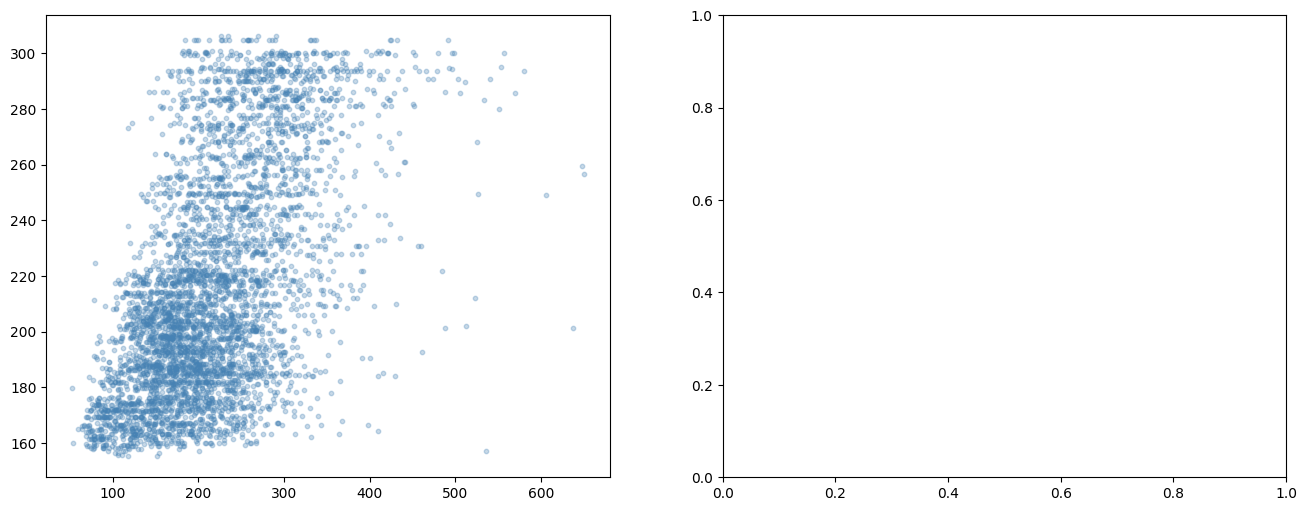

In [ ]:
# Mục đích: Xem model dự đoán tốt như thế nào

import matplotlib.pyplot as plt
import numpy as np

# Lấy sample để vẽ (không vẽ hết sẽ chậm)
sample_predictions = predictions_simple.select(
    'nsmiles', 'fare', 'fare_pred'
).sample(False, 0.1, seed=42).toPandas()

# Tạo figure với 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Actual vs Predicted scatter plot
axes[0].scatter(sample_predictions['fare'], sample_predictions['fare_pred'],
                alpha=0.3, s=10, color='steelblue')

# Thêm đường perfect prediction (45 degree line)
min_val = min(sample_predictions['fare'].min(), sample_predictions['fare_pred'].min())
max_val = max(sample_predictions['fare'].max(), sample_predictions['fare_pred'].max())
axes[0].plot([min_val, max_val], [min_val, max_val],
             'r--', linewidth=2, label='Perfect Prediction')

axes[0].set_xlabel('Giá vé thực tế ($)', fontsize=12)
axes[0].set_ylabel('Giá vé dự đoán ($)', fontsize=12)
axes[0].set_title('Actual vs Predicted Fare', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Thêm R² lên plot
axes[0].text(0.05, 0.95, f'R² = {r2_simple:.4f}\nRMSE = ${rmse_simple:.2f}',
             transform=axes[0].transAxes, fontsize=11,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. Prediction by distance
axes[1].scatter(sample_predictions['nsmiles'], sample_predictions['fare'],
                alpha=0.3, s=10, color='gray', label='Actual')
axes[1].scatter(sample_predictions['nsmiles'], sample_predictions['fare_pred'],
                alpha=0.3, s=10, color='red', label='Predicted')

axes[1].set_xlabel('Khoảng cách (miles)', fontsize=12)
axes[1].set_ylabel('Giá vé ($)', fontsize=12)
axes[1].set_title('Fare by Distance: Actual vs Predicted', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../image/lr_simple_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../image/lr_simple_residuals.png'

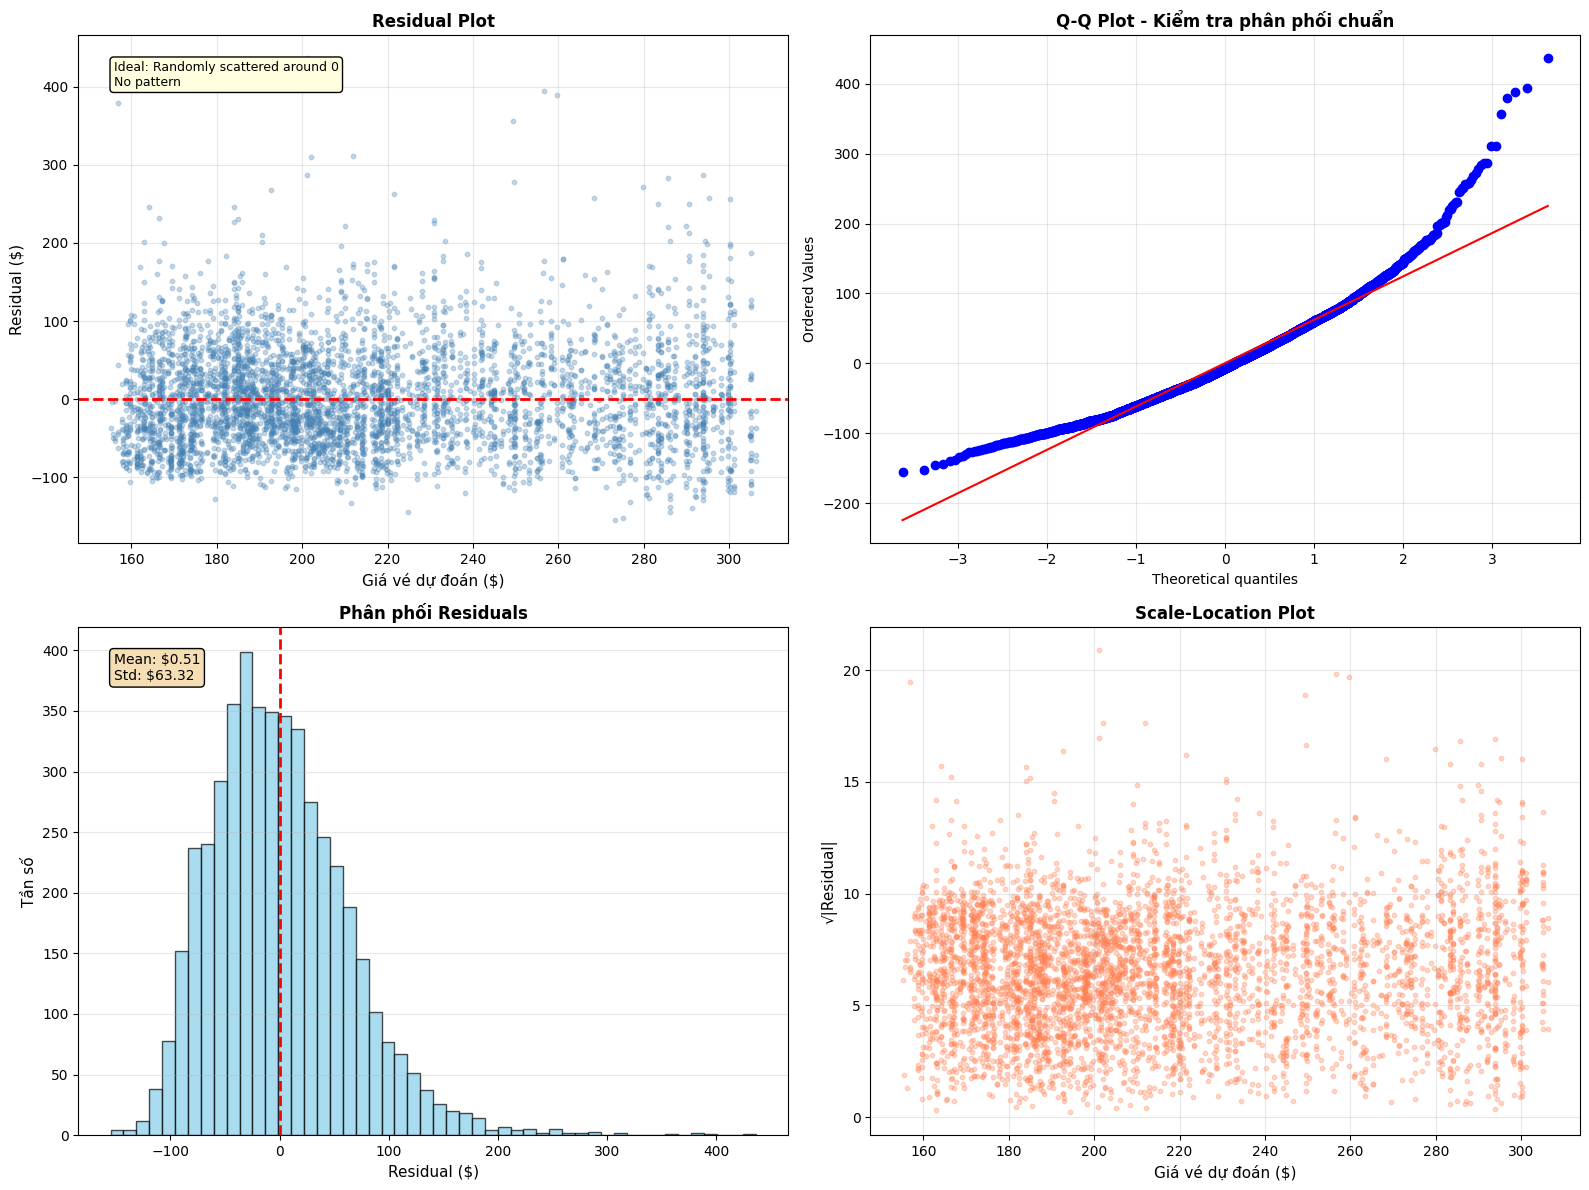

In [ ]:
# Mục đích: Kiểm tra assumptions của Linear Regression

# Tính residuals
sample_predictions['residual'] = sample_predictions['fare'] - sample_predictions['fare_pred']

# Tạo figure với 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Residual vs Predicted (kiểm tra homoscedasticity)
axes[0, 0].scatter(sample_predictions['fare_pred'], sample_predictions['residual'],
                   alpha=0.3, s=10, color='steelblue')
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Giá vé dự đoán ($)', fontsize=11)
axes[0, 0].set_ylabel('Residual ($)', fontsize=11)
axes[0, 0].set_title('Residual Plot', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Thêm note
axes[0, 0].text(0.05, 0.95, 'Ideal: Randomly scattered around 0\nNo pattern',
                transform=axes[0, 0].transAxes, fontsize=9,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightyellow'))

# 2. Q-Q Plot (kiểm tra normality)
from scipy import stats
stats.probplot(sample_predictions['residual'], dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot - Kiểm tra phân phối chuẩn', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Histogram của residuals
axes[1, 0].hist(sample_predictions['residual'], bins=50,
                edgecolor='black', alpha=0.7, color='skyblue')
axes[1, 0].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Residual ($)', fontsize=11)
axes[1, 0].set_ylabel('Tần số', fontsize=11)
axes[1, 0].set_title('Phân phối Residuals', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Thêm thống kê
mean_res = sample_predictions['residual'].mean()
std_res = sample_predictions['residual'].std()
axes[1, 0].text(0.05, 0.95, f'Mean: ${mean_res:.2f}\nStd: ${std_res:.2f}',
                transform=axes[1, 0].transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat'))

# 4. Scale-Location plot (kiểm tra homoscedasticity)
sqrt_abs_residuals = np.sqrt(np.abs(sample_predictions['residual']))
axes[1, 1].scatter(sample_predictions['fare_pred'], sqrt_abs_residuals,
                   alpha=0.3, s=10, color='coral')
axes[1, 1].set_xlabel('Giá vé dự đoán ($)', fontsize=11)
axes[1, 1].set_ylabel('√|Residual|', fontsize=11)
axes[1, 1].set_title('Scale-Location Plot', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../image/lr_simple_residuals.png', dpi=300, bbox_inches='tight')
plt.show()

# Kiểm tra assumptions
print("=" * 60)
print("KIỂM TRA ASSUMPTIONS CỦA LINEAR REGRESSION")
print("=" * 60)

print(f"\n1. LINEARITY: Kiểm tra từ Residual Plot")
print(f"   ✓ Nếu residuals phân tán ngẫu nhiên quanh 0 → OK")

print(f"\n2. NORMALITY: Kiểm tra từ Q-Q Plot")
print(f"   Mean của residuals: ${mean_res:.4f}")
print(f"   ✓ Nếu mean ≈ 0 và Q-Q plot gần đường thẳng → OK")

print(f"\n3. HOMOSCEDASTICITY: Kiểm tra từ Scale-Location Plot")
print(f"   Std của residuals: ${std_res:.2f}")
print(f"   ✓ Nếu variance không tăng theo predicted values → OK")

print(f"\n4. INDEPENDENCE: Cần kiểm tra autocorrelation")
print(f"   (Không áp dụng cho cross-sectional data này)")

PHÂN TÍCH LỖI DỰ ĐOÁN

📊 THỐNG KÊ LỖI:
  Mean Absolute Error:     $49.21
  Median Absolute Error:   $41.37
  Max Absolute Error:      $436.11
  Mean Percentage Error:   26.02%

📈 PHÂN LOẠI THEO MỨC ĐỘ LỖI:
  Lỗi thấp  (<$30):   1,727 (36.6%)
  Lỗi trung bình ($30-100): 2,587 (54.8%)
  Lỗi cao   (>$100):  410 (8.7%)


/tmp/ipython-input-2709021999.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_distance = sample_predictions.groupby('distance_group')['abs_error'].mean()


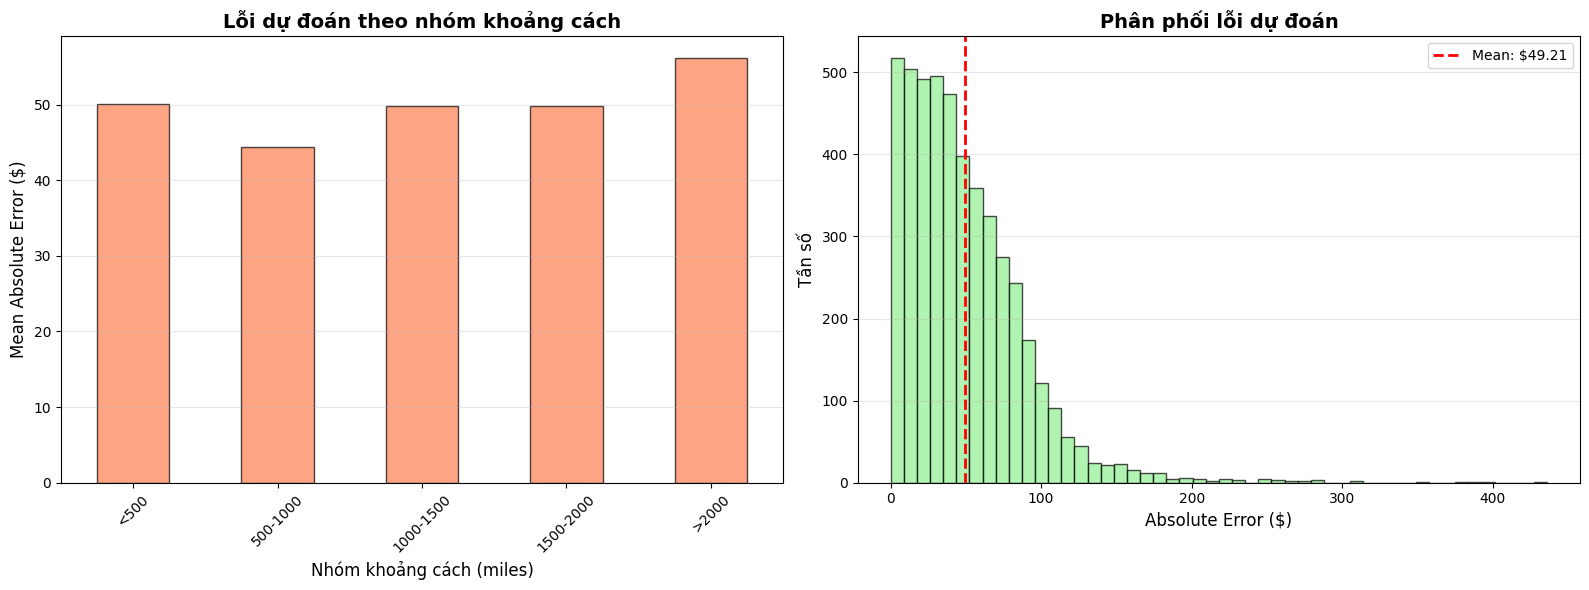


💡 NHẬN XÉT:
  • Model dự đoán tốt nhất ở khoảng cách: 500-1000
  • Model dự đoán kém nhất ở khoảng cách: >2000
  • Cần thêm features để cải thiện accuracy


In [ ]:
# Mục đích: Hiểu model dự đoán kém ở những trường hợp nào

# Tính absolute error
sample_predictions['abs_error'] = np.abs(sample_predictions['residual'])
sample_predictions['pct_error'] = (sample_predictions['abs_error'] / sample_predictions['fare']) * 100

# Tìm top errors
top_errors = sample_predictions.nlargest(20, 'abs_error')

print("=" * 60)
print("PHÂN TÍCH LỖI DỰ ĐOÁN")
print("=" * 60)

print(f"\n📊 THỐNG KÊ LỖI:")
print(f"  Mean Absolute Error:     ${sample_predictions['abs_error'].mean():.2f}")
print(f"  Median Absolute Error:   ${sample_predictions['abs_error'].median():.2f}")
print(f"  Max Absolute Error:      ${sample_predictions['abs_error'].max():.2f}")
print(f"  Mean Percentage Error:   {sample_predictions['pct_error'].mean():.2f}%")

# Phân loại error levels
low_error = sample_predictions[sample_predictions['abs_error'] < 30]
medium_error = sample_predictions[(sample_predictions['abs_error'] >= 30) &
                                   (sample_predictions['abs_error'] < 100)]
high_error = sample_predictions[sample_predictions['abs_error'] >= 100]

print(f"\n📈 PHÂN LOẠI THEO MỨC ĐỘ LỖI:")
print(f"  Lỗi thấp  (<$30):   {len(low_error):,} ({len(low_error)/len(sample_predictions)*100:.1f}%)")
print(f"  Lỗi trung bình ($30-100): {len(medium_error):,} ({len(medium_error)/len(sample_predictions)*100:.1f}%)")
print(f"  Lỗi cao   (>$100):  {len(high_error):,} ({len(high_error)/len(sample_predictions)*100:.1f}%)")

# Visualize error distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Error by distance groups
distance_bins = [0, 500, 1000, 1500, 2000, 3000]
distance_labels = ['<500', '500-1000', '1000-1500', '1500-2000', '>2000']
sample_predictions['distance_group'] = pd.cut(sample_predictions['nsmiles'],
                                               bins=distance_bins, labels=distance_labels)

error_by_distance = sample_predictions.groupby('distance_group')['abs_error'].mean()
error_by_distance.plot(kind='bar', ax=axes[0], color='coral', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Nhóm khoảng cách (miles)', fontsize=12)
axes[0].set_ylabel('Mean Absolute Error ($)', fontsize=12)
axes[0].set_title('Lỗi dự đoán theo nhóm khoảng cách', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

# 2. Error distribution
axes[1].hist(sample_predictions['abs_error'], bins=50,
             edgecolor='black', alpha=0.7, color='lightgreen')
axes[1].axvline(x=sample_predictions['abs_error'].mean(),
                color='r', linestyle='--', linewidth=2, label=f'Mean: ${sample_predictions["abs_error"].mean():.2f}')
axes[1].set_xlabel('Absolute Error ($)', fontsize=12)
axes[1].set_ylabel('Tần số', fontsize=12)
axes[1].set_title('Phân phối lỗi dự đoán', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n💡 NHẬN XÉT:")
print(f"  • Model dự đoán tốt nhất ở khoảng cách: {error_by_distance.idxmin()}")
print(f"  • Model dự đoán kém nhất ở khoảng cách: {error_by_distance.idxmax()}")
print(f"  • Cần thêm features để cải thiện accuracy")

In [ ]:

# LINEAR REGRESSION - NHIỀU FEATURE

print("LINEAR REGRESSION - MULTI FEATURES")

# Chọn features
feature_cols = ['nsmiles', 'quarter', 'Year', 'passengers']

print(f"\n📋 FEATURES SỬ DỤNG:")
for i, feat in enumerate(feature_cols, 1):
    print(f"  {i}. {feat}")

# Bước 1: Tạo feature vector
assembler_multi = VectorAssembler(
    inputCols=feature_cols,
    outputCol='features',
    handleInvalid='skip'
)

# Bước 2: Chuẩn hóa features
scaler_multi = StandardScaler(
    inputCol='features',
    outputCol='scaled_features',
    withStd=True,
    withMean=True
)

# Bước 3: Tạo Linear Regression model
lr_multi = LinearRegression(
    featuresCol='scaled_features',
    labelCol='fare',
    predictionCol='fare_pred_multi',
    maxIter=100,
    regParam=0.01,
    elasticNetParam=0.0,
    tol=1e-6
)

# Bước 4: Tạo pipeline
pipeline_multi = Pipeline(stages=[
    assembler_multi,
    scaler_multi,
    lr_multi
])

# Bước 5: Train model
print(f"\nĐang training model với {len(feature_cols)} features...")
model_multi = pipeline_multi.fit(train_data)
print("✓ Training hoàn thành!")

# Lưu model để dễ truy cập
lr_multi_model = model_multi.stages[-1]

LINEAR REGRESSION - MULTI FEATURES

📋 FEATURES SỬ DỤNG:
  1. nsmiles
  2. quarter
  3. Year
  4. passengers

Đang training model với 4 features...
✓ Training hoàn thành!


In [ ]:
# Mục đích: So sánh với baseline model

# Dự đoán trên test set
predictions_multi = model_multi.transform(test_data)

# Tính metrics
r2_multi = RegressionEvaluator(
    labelCol='fare', predictionCol='fare_pred_multi', metricName='r2'
).evaluate(predictions_multi)

rmse_multi = RegressionEvaluator(
    labelCol='fare', predictionCol='fare_pred_multi', metricName='rmse'
).evaluate(predictions_multi)

mae_multi = RegressionEvaluator(
    labelCol='fare', predictionCol='fare_pred_multi', metricName='mae'
).evaluate(predictions_multi)

# Hiển thị kết quả
print("=" * 70)
print("KẾT QUẢ MULTI-FEATURE LINEAR REGRESSION")
print("=" * 70)

print(f"\n📊 HIỆU SUẤT TRÊN TEST SET:")
print(f"  R² (R-squared):     {r2_multi:.4f}  ({r2_multi*100:.2f}%)")
print(f"  RMSE (Root MSE):    ${rmse_multi:.2f}")
print(f"  MAE (Mean Abs Err): ${mae_multi:.2f}")

# So sánh với baseline
print(f"\n📈 SO SÁNH VỚI BASELINE (Distance only):")
print(f"{'Metric':<20} {'Baseline':>12} {'Multi-Feature':>15} {'Improvement':>15}")
print("-" * 65)

r2_improvement = ((r2_multi - r2_simple) / r2_simple) * 100
rmse_improvement = ((rmse_simple - rmse_multi) / rmse_simple) * 100
mae_improvement = ((mae_simple - mae_multi) / mae_simple) * 100

print(f"{'R²':<20} {r2_simple:>12.4f} {r2_multi:>15.4f} {r2_improvement:>14.2f}%")
print(f"{'RMSE':<20} ${rmse_simple:>11.2f} ${rmse_multi:>14.2f} {rmse_improvement:>14.2f}%")
print(f"{'MAE':<20} ${mae_simple:>11.2f} ${mae_multi:>14.2f} {mae_improvement:>14.2f}%")

print(f"\n💡 NHẬN XÉT:")
if r2_improvement > 10:
    print(f"  ✅ CẢI THIỆN ĐÁNG KỂ: R² tăng {r2_improvement:.1f}%")
    print(f"  ✅ Model giải thích thêm được {(r2_multi - r2_simple)*100:.1f}% variance")
elif r2_improvement > 5:
    print(f"  ⚠️  Cải thiện vừa phải: R² tăng {r2_improvement:.1f}%")
else:
    print(f"  ❌ Cải thiện ít: R² chỉ tăng {r2_improvement:.1f}%")

print(f"  • Variance explained: {r2_simple*100:.1f}% → {r2_multi*100:.1f}%")
print(f"  • Sai số giảm: ${rmse_simple:.2f} → ${rmse_multi:.2f}")

KẾT QUẢ MULTI-FEATURE LINEAR REGRESSION

📊 HIỆU SUẤT TRÊN TEST SET:
  R² (R-squared):     0.3535  (35.35%)
  RMSE (Root MSE):    $59.56
  MAE (Mean Abs Err): $45.94

📈 SO SÁNH VỚI BASELINE (Distance only):
Metric                   Baseline   Multi-Feature     Improvement
-----------------------------------------------------------------
R²                         0.3049          0.3535          15.93%
RMSE                 $      61.76 $         59.56           3.56%
MAE                  $      48.45 $         45.94           5.18%

💡 NHẬN XÉT:
  ✅ CẢI THIỆN ĐÁNG KỂ: R² tăng 15.9%
  ✅ Model giải thích thêm được 4.9% variance
  • Variance explained: 30.5% → 35.4%
  • Sai số giảm: $61.76 → $59.56


In [ ]:
# ============================================================
# CELL 7A: POLYNOMIAL REGRESSION - BẬC 2
# ============================================================
# Mục đích: Thêm các polynomial terms để capture non-linearity

from pyspark.ml.feature import PolynomialExpansion

print("=" * 70)
print("POLYNOMIAL REGRESSION - BẬC 2")
print("=" * 70)

# Bước 1: Tạo feature vector
assembler_poly = VectorAssembler(
    inputCols=['nsmiles', 'quarter', 'Year', 'passengers'],
    outputCol='features',
    handleInvalid='skip'
)

# Bước 2: Chuẩn hóa trước khi polynomial expansion (quan trọng!)
scaler_poly = StandardScaler(
    inputCol='features',
    outputCol='scaled_features',
    withStd=True,
    withMean=True
)

# Bước 3: Polynomial expansion (degree=2)
# Tạo các terms: x1, x2, x1², x2², x1×x2, ...
poly_expansion = PolynomialExpansion(
    degree=2,  # Bậc 2
    inputCol='scaled_features',
    outputCol='poly_features'
)

print(f"\n📐 POLYNOMIAL FEATURES:")
print(f"  • Input features: 4 (nsmiles, quarter, Year, passengers)")
print(f"  • Polynomial degree: 2")
print(f"  • Output features: {(4+2)*(4+1)//2} = 15")
print(f"    (bao gồm: x1, x2, x3, x4, x1², x2², x3², x4², x1×x2, x1×x3, ...)")

# Bước 4: Linear Regression với polynomial features
lr_poly = LinearRegression(
    featuresCol='poly_features',
    labelCol='fare',
    predictionCol='fare_pred_poly',
    maxIter=100,
    regParam=0.1,  # Tăng regularization để tránh overfitting
    elasticNetParam=0.0,
    tol=1e-6
)

# Bước 5: Tạo pipeline
pipeline_poly = Pipeline(stages=[
    assembler_poly,
    scaler_poly,
    poly_expansion,
    lr_poly
])

# Bước 6: Train model
print(f"\nĐang training Polynomial Regression...")
model_poly = pipeline_poly.fit(train_data)
print("✓ Training hoàn thành!")

lr_poly_model = model_poly.stages[-1]

POLYNOMIAL REGRESSION - BẬC 2

📐 POLYNOMIAL FEATURES:
  • Input features: 4 (nsmiles, quarter, Year, passengers)
  • Polynomial degree: 2
  • Output features: 15 = 15
    (bao gồm: x1, x2, x3, x4, x1², x2², x3², x4², x1×x2, x1×x3, ...)

Đang training Polynomial Regression...
✓ Training hoàn thành!


In [ ]:
# Mục đích: So sánh với Linear models

# Dự đoán
predictions_poly = model_poly.transform(test_data)

# Tính metrics
r2_poly = RegressionEvaluator(
    labelCol='fare', predictionCol='fare_pred_poly', metricName='r2'
).evaluate(predictions_poly)

rmse_poly = RegressionEvaluator(
    labelCol='fare', predictionCol='fare_pred_poly', metricName='rmse'
).evaluate(predictions_poly)

mae_poly = RegressionEvaluator(
    labelCol='fare', predictionCol='fare_pred_poly', metricName='mae'
).evaluate(predictions_poly)

# Hiển thị kết quả
print("=" * 70)
print("KẾT QUẢ POLYNOMIAL REGRESSION (Bậc 2)")
print("=" * 70)

print(f"\n📊 HIỆU SUẤT TRÊN TEST SET:")
print(f"  R² (R-squared):     {r2_poly:.4f}  ({r2_poly*100:.2f}%)")
print(f"  RMSE (Root MSE):    ${rmse_poly:.2f}")
print(f"  MAE (Mean Abs Err): ${mae_poly:.2f}")

# So sánh 3 models
print(f"\n📈 SO SÁNH 3 MODELS:")
print(f"{'Model':<30} {'R²':>12} {'RMSE':>12} {'MAE':>12} {'Features':>10}")
print("-" * 80)
print(f"{'1. Linear (Distance only)':<30} {r2_simple:>12.4f} ${rmse_simple:>11.2f} ${mae_simple:>11.2f} {'1':>10}")
print(f"{'2. Linear (Multi-feature)':<30} {r2_multi:>12.4f} ${rmse_multi:>11.2f} ${mae_multi:>11.2f} {'4':>10}")
print(f"{'3. Polynomial (Degree 2)':<30} {r2_poly:>12.4f} ${rmse_poly:>11.2f} ${mae_poly:>11.2f} {'15':>10}")

# Tính improvement
poly_vs_linear = ((r2_poly - r2_multi) / r2_multi) * 100
poly_vs_baseline = ((r2_poly - r2_simple) / r2_simple) * 100

print(f"\n💡 CẢI THIỆN:")
print(f"  • Polynomial vs Linear Multi-feature: +{poly_vs_linear:.2f}%")
print(f"  • Polynomial vs Baseline: +{poly_vs_baseline:.2f}%")

if r2_poly > r2_multi:
    print(f"\n  ✅ Polynomial tốt hơn Linear Multi-feature")
    print(f"  ✅ Phi tuyến tính capture được patterns tốt hơn")
else:
    print(f"\n  ⚠️  Polynomial không cải thiện nhiều")
    print(f"  ⚠️  Có thể cần degree cao hơn hoặc model khác")

KẾT QUẢ POLYNOMIAL REGRESSION (Bậc 2)

📊 HIỆU SUẤT TRÊN TEST SET:
  R² (R-squared):     0.3729  (37.29%)
  RMSE (Root MSE):    $58.66
  MAE (Mean Abs Err): $44.95

📈 SO SÁNH 3 MODELS:
Model                                    R²         RMSE          MAE   Features
--------------------------------------------------------------------------------
1. Linear (Distance only)            0.3049 $      61.76 $      48.45          1
2. Linear (Multi-feature)            0.3535 $      59.56 $      45.94          4
3. Polynomial (Degree 2)             0.3729 $      58.66 $      44.95         15

💡 CẢI THIỆN:
  • Polynomial vs Linear Multi-feature: +5.49%
  • Polynomial vs Baseline: +22.30%

  ✅ Polynomial tốt hơn Linear Multi-feature
  ✅ Phi tuyến tính capture được patterns tốt hơn


In [ ]:
# ============================================================
# CELL 7C: THỬ NGHIỆM NHIỀU POLYNOMIAL DEGREES
# ============================================================
# Mục đích: Tìm degree tối ưu, kiểm tra overfitting

print("=" * 70)
print("THỬ NGHIỆM NHIỀU POLYNOMIAL DEGREES")
print("=" * 70)

degrees = [1, 2, 3, 4]
results = []

for degree in degrees:
    print(f"\nĐang train với degree = {degree}...")

    # Tạo pipeline cho degree này
    poly_exp = PolynomialExpansion(
        degree=degree,
        inputCol='scaled_features',
        outputCol='poly_features'
    )

    lr_temp = LinearRegression(
        featuresCol='poly_features',
        labelCol='fare',
        predictionCol='fare_pred',
        maxIter=100,
        regParam=0.1,
        elasticNetParam=0.0
    )

    pipeline_temp = Pipeline(stages=[
        assembler_poly,
        scaler_poly,
        poly_exp,
        lr_temp
    ])

    # Train
    model_temp = pipeline_temp.fit(train_data)

    # Evaluate trên cả train và test
    pred_train = model_temp.transform(train_data)
    pred_test = model_temp.transform(test_data)

    r2_train = RegressionEvaluator(
        labelCol='fare', predictionCol='fare_pred', metricName='r2'
    ).evaluate(pred_train)

    r2_test = RegressionEvaluator(
        labelCol='fare', predictionCol='fare_pred', metricName='r2'
    ).evaluate(pred_test)

    rmse_train = RegressionEvaluator(
        labelCol='fare', predictionCol='fare_pred', metricName='rmse'
    ).evaluate(pred_train)

    rmse_test = RegressionEvaluator(
        labelCol='fare', predictionCol='fare_pred', metricName='rmse'
    ).evaluate(pred_test)

    # Tính số features
    num_features = pred_test.select('poly_features').first()[0].size

    results.append({
        'Degree': degree,
        'Num_Features': num_features,
        'R2_Train': r2_train,
        'R2_Test': r2_test,
        'RMSE_Train': rmse_train,
        'RMSE_Test': rmse_test,
        'Overfit_Gap': r2_train - r2_test
    })

    print(f"  ✓ Degree {degree}: R² Train={r2_train:.4f}, Test={r2_test:.4f}, Gap={r2_train-r2_test:.4f}")

# Tạo DataFrame
results_df = pd.DataFrame(results)

print(f"\n" + "=" * 70)
print("KẾT QUẢ TỔNG HỢP")
print("=" * 70)
print(results_df.to_string(index=False))

# Tìm degree tốt nhất
best_degree_idx = results_df['R2_Test'].idxmax()
best_degree = results_df.loc[best_degree_idx, 'Degree']
best_r2 = results_df.loc[best_degree_idx, 'R2_Test']

print(f"\n🏆 DEGREE TỐI ƯU: {int(best_degree)}")
print(f"  • R² Test: {best_r2:.4f}")
print(f"  • Overfitting gap: {results_df.loc[best_degree_idx, 'Overfit_Gap']:.4f}")

THỬ NGHIỆM NHIỀU POLYNOMIAL DEGREES

Đang train với degree = 1...
  ✓ Degree 1: R² Train=0.3490, Test=0.3535, Gap=-0.0045

Đang train với degree = 2...
  ✓ Degree 2: R² Train=0.3702, Test=0.3729, Gap=-0.0028

Đang train với degree = 3...
  ✓ Degree 3: R² Train=0.3959, Test=0.3957, Gap=0.0002

Đang train với degree = 4...
  ✓ Degree 4: R² Train=0.4041, Test=0.4042, Gap=-0.0000

KẾT QUẢ TỔNG HỢP
 Degree  Num_Features  R2_Train  R2_Test  RMSE_Train  RMSE_Test  Overfit_Gap
      1             4  0.349008 0.353508   60.001665  59.562801    -0.004499
      2            14  0.370176 0.372927   59.018086  58.661429    -0.002750
      3            34  0.395862 0.395705   57.802128  57.586128     0.000156
      4            69  0.404108 0.404155   57.406281  57.182091    -0.000047

🏆 DEGREE TỐI ƯU: 4
  • R² Test: 0.4042
  • Overfitting gap: -0.0000


FileNotFoundError: [Errno 2] No such file or directory: '../image/polynomial_degree_comparison.png'

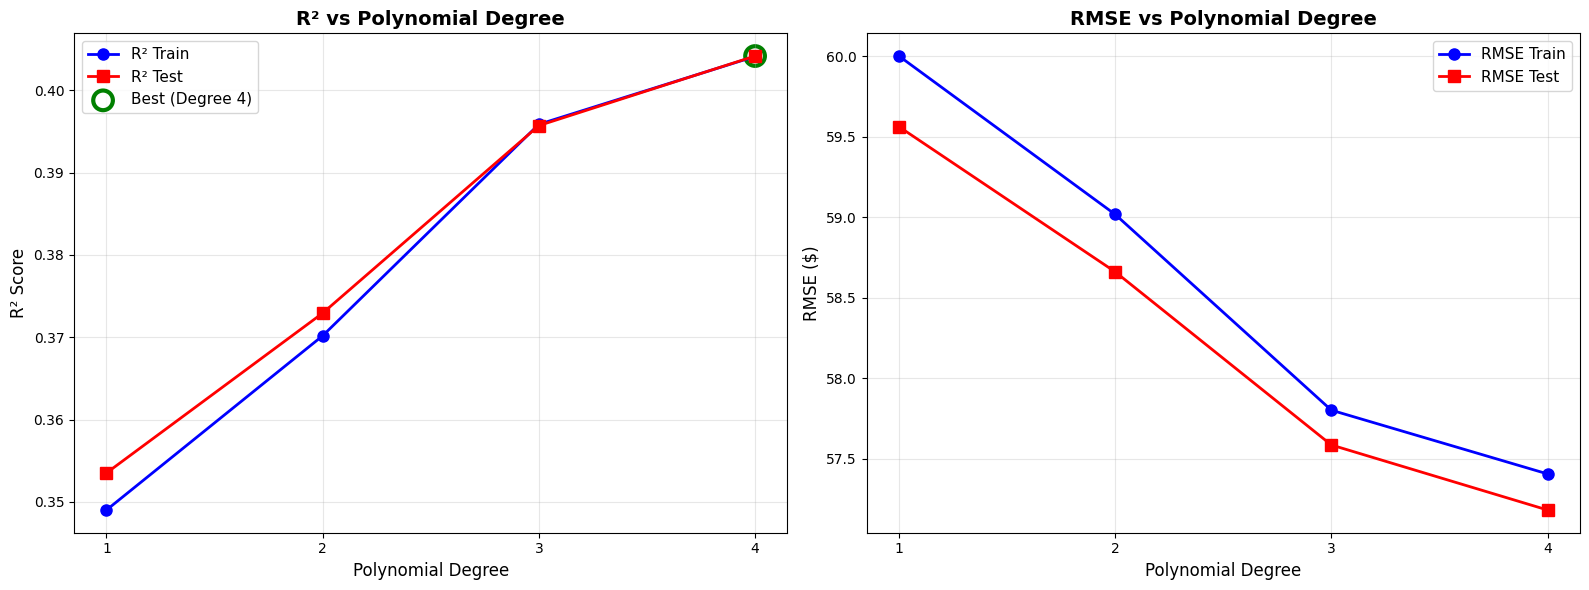

In [ ]:
# Mục đích: Xem xu hướng overfitting

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. R² comparison: Train vs Test
axes[0].plot(results_df['Degree'], results_df['R2_Train'],
             marker='o', linewidth=2, markersize=8, label='R² Train', color='blue')
axes[0].plot(results_df['Degree'], results_df['R2_Test'],
             marker='s', linewidth=2, markersize=8, label='R² Test', color='red')
axes[0].set_xlabel('Polynomial Degree', fontsize=12)
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_title('R² vs Polynomial Degree', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(results_df['Degree'])

# Highlight best degree
best_idx = results_df['R2_Test'].idxmax()
axes[0].scatter(results_df.loc[best_idx, 'Degree'],
                results_df.loc[best_idx, 'R2_Test'],
                s=200, facecolors='none', edgecolors='green', linewidths=3,
                label=f'Best (Degree {int(results_df.loc[best_idx, "Degree"])})')
axes[0].legend(fontsize=11)

# 2. RMSE comparison: Train vs Test
axes[1].plot(results_df['Degree'], results_df['RMSE_Train'],
             marker='o', linewidth=2, markersize=8, label='RMSE Train', color='blue')
axes[1].plot(results_df['Degree'], results_df['RMSE_Test'],
             marker='s', linewidth=2, markersize=8, label='RMSE Test', color='red')
axes[1].set_xlabel('Polynomial Degree', fontsize=12)
axes[1].set_ylabel('RMSE ($)', fontsize=12)
axes[1].set_title('RMSE vs Polynomial Degree', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(results_df['Degree'])

plt.tight_layout()
plt.savefig('../image/polynomial_degree_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Phân tích overfitting
print("\n" + "=" * 70)
print("PHÂN TÍCH OVERFITTING")
print("=" * 70)

for _, row in results_df.iterrows():
    gap = row['Overfit_Gap']
    degree = int(row['Degree'])

    if gap < 0.01:
        status = "✅ GOOD - Không overfitting"
    elif gap < 0.03:
        status = "⚠️  WARNING - Overfitting nhẹ"
    else:
        status = "❌ BAD - Overfitting nghiêm trọng"

    print(f"  Degree {degree}: Gap = {gap:.4f} → {status}")

print(f"\n💡 KHUYẾN NGHỊ:")
if results_df.loc[best_idx, 'Overfit_Gap'] < 0.02:
    print(f"  ✅ Sử dụng Polynomial Degree {int(best_degree)}")
    print(f"  ✅ Cân bằng tốt giữa performance và generalization")
else:
    print(f"  ⚠️  Degree {int(best_degree)} có overfitting")
    print(f"  ⚠️  Cân nhắc dùng regularization mạnh hơn hoặc degree thấp hơn")

SO SÁNH TOÀN DIỆN - TẤT CẢ MODELS

                Model       R²      RMSE  Num_Features Complexity
  Baseline (Distance) 0.304939 61.759668             1        Low
 Linear Multi-feature 0.353507 59.562858             4     Medium
Polynomial (Degree 4) 0.404155 57.182091            69       High


FileNotFoundError: [Errno 2] No such file or directory: '../image/final_model_comparison.png'

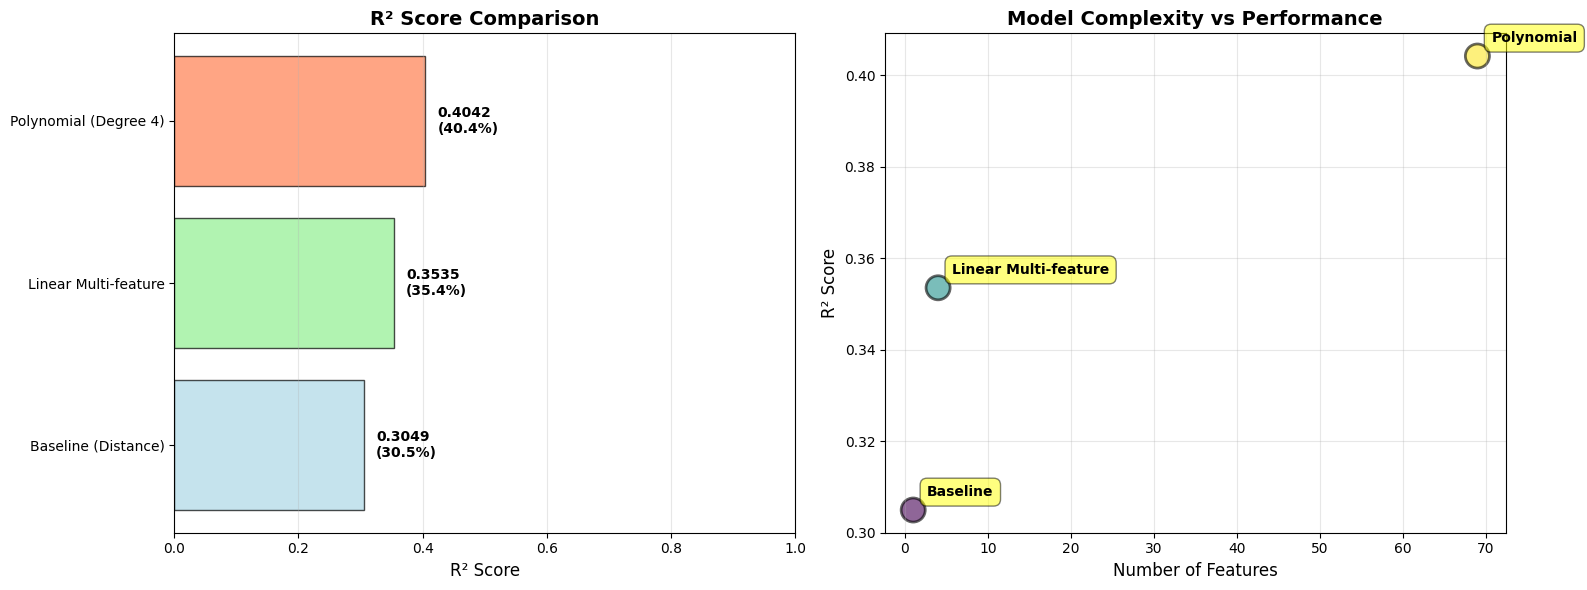

In [ ]:
# ============================================================
# CELL 7E: SO SÁNH CUỐI CÙNG - TẤT CẢ MODELS
# ============================================================
# Mục đích: Quyết định model nào tốt nhất

# Tổng hợp tất cả kết quả
final_comparison = pd.DataFrame({
    'Model': [
        'Baseline (Distance)',
        'Linear Multi-feature',
        f'Polynomial (Degree {int(best_degree)})'
    ],
    'R²': [r2_simple, r2_multi, best_r2],
    'RMSE': [rmse_simple, rmse_multi, results_df.loc[best_idx, 'RMSE_Test']],
    'Num_Features': [1, 4, int(results_df.loc[best_idx, 'Num_Features'])],
    'Complexity': ['Low', 'Medium', 'High']
})

print("=" * 70)
print("SO SÁNH TOÀN DIỆN - TẤT CẢ MODELS")
print("=" * 70)
print()
print(final_comparison.to_string(index=False))

# Visualize final comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. R² comparison
models = final_comparison['Model']
r2_values = final_comparison['R²']
colors = ['lightblue', 'lightgreen', 'coral']

bars = axes[0].barh(models, r2_values, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('R² Score', fontsize=12)
axes[0].set_title('R² Score Comparison', fontsize=14, fontweight='bold')
axes[0].set_xlim(0, 1)
axes[0].grid(True, alpha=0.3, axis='x')

for bar, val in zip(bars, r2_values):
    width = bar.get_width()
    axes[0].text(width + 0.02, bar.get_y() + bar.get_height()/2,
                 f'{val:.4f}\n({val*100:.1f}%)',
                 ha='left', va='center', fontweight='bold', fontsize=10)

# 2. Complexity vs Performance
axes[1].scatter(final_comparison['Num_Features'], final_comparison['R²'],
                s=300, c=range(len(final_comparison)), cmap='viridis',
                alpha=0.6, edgecolors='black', linewidths=2)

for i, row in final_comparison.iterrows():
    axes[1].annotate(row['Model'].split('(')[0].strip(),
                     (row['Num_Features'], row['R²']),
                     xytext=(10, 10), textcoords='offset points',
                     fontsize=10, fontweight='bold',
                     bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.5))

axes[1].set_xlabel('Number of Features', fontsize=12)
axes[1].set_ylabel('R² Score', fontsize=12)
axes[1].set_title('Model Complexity vs Performance', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../image/final_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Kết luận và đề xuất
print("\n" + "=" * 70)
print("KẾT LUẬN VÀ KHUYẾN NGHỊ")
print("=" * 70)

best_model_idx = final_comparison['R²'].idxmax()
best_model_name = final_comparison.loc[best_model_idx, 'Model']
best_model_r2 = final_comparison.loc[best_model_idx, 'R²']

print(f"\n🏆 MODEL TỐT NHẤT: {best_model_name}")
print(f"  • R²: {best_model_r2:.4f} ({best_model_r2*100:.1f}% variance explained)")
print(f"  • RMSE: ${final_comparison.loc[best_model_idx, "RMSE"]:.2f}")

print(f"\n📊 SO SÁNH:")
baseline_r2 = final_comparison.loc[0, 'R²']
improvement = ((best_model_r2 - baseline_r2) / baseline_r2) * 100
print(f"  • Cải thiện so với baseline: +{improvement:.1f}%")
print(f"  • Variance explained tăng: {baseline_r2*100:.1f}% → {best_model_r2*100:.1f}%")

print(f"\n💭 ĐÁNH GIÁ:")
if best_model_r2 < 0.4:
    print(f"  ⚠️  R² vẫn thấp (<40%), cần:")
    print(f"     • Thêm nhiều features hơn (carrier, competition, seasonality)")
    print(f"     • Thử mô hình phi tuyến mạnh hơn (Random Forest, Gradient Boosting)")
    print(f"     • Feature engineering (interaction terms, categorical encoding)")
elif best_model_r2 < 0.6:
    print(f"  ✅ R² ở mức chấp nhận được (40-60%)")
    print(f"  ✅ Model có thể dùng được nhưng vẫn có thể cải thiện")
else:
    print(f"  ✅✅ R² tốt (>60%)")
    print(f"  ✅✅ Model rất đáng tin cậy")

print(f"\n🚀 BƯỚC TIẾP THEO:")
print(f"  1. Thử Random Forest (capture non-linearity tốt hơn)")
print(f"  2. Feature engineering: thêm carrier_type, route_category")
print(f"  3. Ensemble methods: XGBoost, LightGBM")
print(f"  4. Hyperparameter tuning với Grid Search")

In [ ]:
# ============================================================
# PHÁT HIỆN BẤT THƯỜNG TRONG GIAI ĐOẠN COVID-19
# ============================================================
# Mục đích: Phân tích ảnh hưởng của COVID-19 lên ngành hàng không

print("PHÁT HIỆN BẤT THƯỜNG: ẢNH HƯỞNG COVID-19")

# Định nghĩa các giai đoạn
pre_covid = (1993, 2019)
covid_period = (2020, 2021)
post_covid = (2022, 2024)

print(f"\n📅 PHÂN CHIA GIAI ĐOẠN:")
print(f"  • Pre-COVID:  {pre_covid[0]}-{pre_covid[1]} (27 năm)")
print(f"  • COVID:      {covid_period[0]}-{covid_period[1]} (2 năm)")
print(f"  • Post-COVID: {post_covid[0]}-{post_covid[1]} (3 năm)")

# Gán nhãn giai đoạn
from pyspark.sql.functions import when, col, count, avg, sum

df_with_period = df.withColumn('period',
    when((col('Year') >= pre_covid[0]) & (col('Year') <= pre_covid[1]), 'Pre-COVID')
    .when((col('Year') >= covid_period[0]) & (col('Year') <= covid_period[1]), 'COVID')
    .when((col('Year') >= post_covid[0]) & (col('Year') <= post_covid[1]), 'Post-COVID')
    .otherwise('Unknown')
)

# Thống kê theo năm
yearly_stats = df.groupBy('Year').agg(
    count('*').alias('num_routes'),
    avg('fare').alias('avg_fare'),
    sum('passengers').alias('total_passengers'),
    avg('passengers').alias('avg_passengers'),
    avg('nsmiles').alias('avg_distance')
).orderBy('Year').toPandas()

# Thêm period labels
yearly_stats['period'] = yearly_stats['Year'].apply(
    lambda x: 'Pre-COVID' if x <= 2019
    else ('COVID' if x <= 2021 else 'Post-COVID')
)

print("\n📊 DỮ LIỆU THEO NĂM:")
print(yearly_stats.tail(10).to_string(index=False))  # 10 năm gần nhất

PHÁT HIỆN BẤT THƯỜNG: ẢNH HƯỞNG COVID-19

📅 PHÂN CHIA GIAI ĐOẠN:
  • Pre-COVID:  1993-2019 (27 năm)
  • COVID:      2020-2021 (2 năm)
  • Post-COVID: 2022-2024 (3 năm)

📊 DỮ LIỆU THEO NĂM:
 Year  num_routes   avg_fare  total_passengers  avg_passengers  avg_distance     period
 2015        8150 247.992015           2845538      349.145767   1200.745767  Pre-COVID
 2016        8227 240.550512           2977255      361.888295   1201.169928  Pre-COVID
 2017        8232 240.096521           3086637      374.955904   1196.532313  Pre-COVID
 2018        8195 239.809121           3203950      390.964002   1197.654790  Pre-COVID
 2019        8148 241.179140           3262326      400.383652   1193.206186  Pre-COVID
 2020        7520 193.615156           1131511      150.466888   1233.886835      COVID
 2021        7758 206.346408           2133402      274.993813   1208.319799      COVID
 2022        7809 249.667511           2979369      381.530158   1187.468178 Post-COVID
 2023        7788 2

FileNotFoundError: [Errno 2] No such file or directory: '../image/covid_impact_timeline.png'

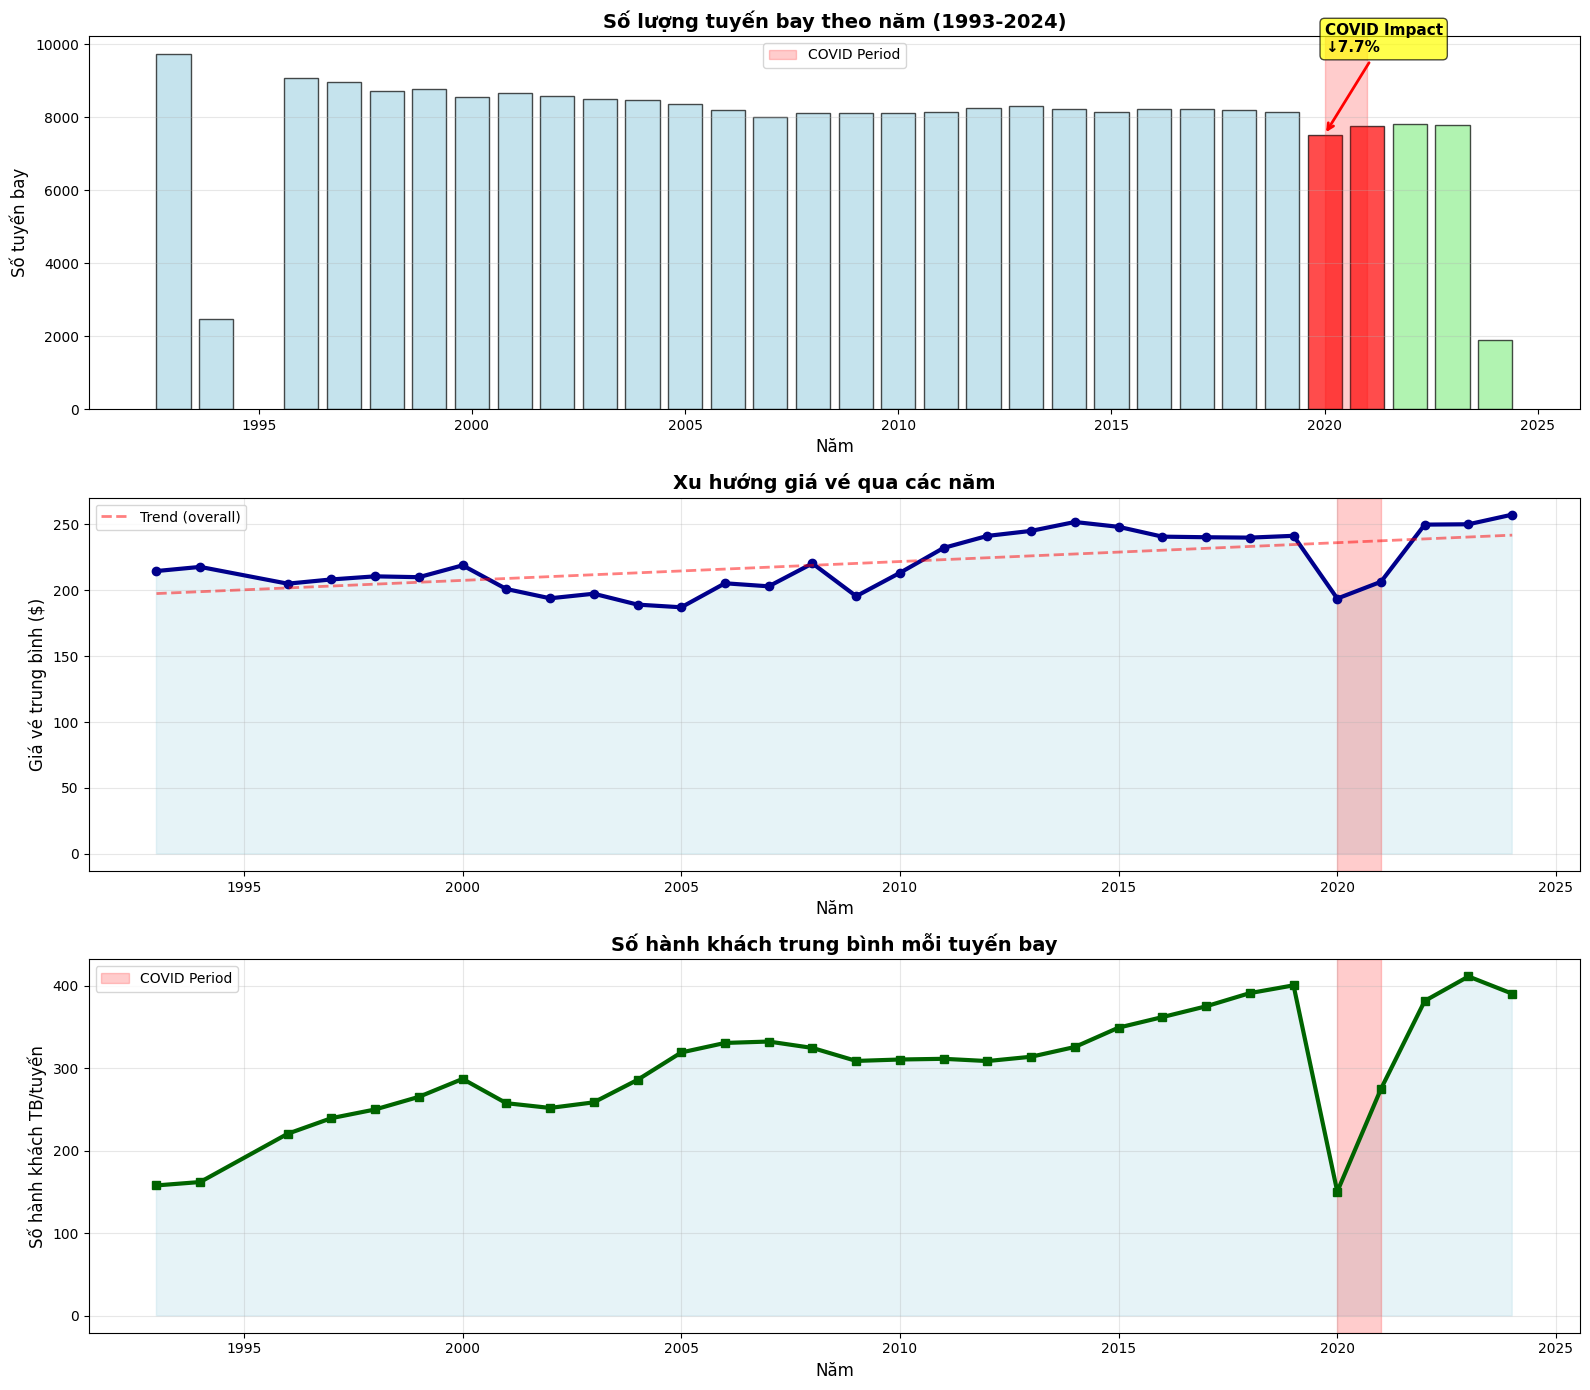

In [ ]:
# ============================================================
# CELL 9B: TRỰC QUAN HÓA TÁC ĐỘNG COVID-19
# ============================================================
# Mục đích: Vẽ timeline để thấy rõ sự thay đổi

import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import when, col, count, avg, sum # This import is likely not needed here as df_with_period is already created

fig, axes = plt.subplots(3, 1, figsize=(16, 14))

# Colors cho periods
colors = yearly_stats['period'].map({
    'Pre-COVID': 'lightblue',
    'COVID': 'red',
    'Post-COVID': 'lightgreen'
})

# 1. SỐ TUYẾN BAY THEO NĂM
axes[0].bar(yearly_stats['Year'], yearly_stats['num_routes'],
            color=colors, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Năm', fontsize=12)
axes[0].set_ylabel('Số tuyến bay', fontsize=12)
axes[0].set_title('Số lượng tuyến bay theo năm (1993-2024)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Highlight COVID period
axes[0].axvspan(2020, 2021, alpha=0.2, color='red', label='COVID Period')

# Thêm annotation
covid_routes = yearly_stats[yearly_stats['Year'] == 2020]['num_routes'].values[0]
pre_covid_avg = yearly_stats[yearly_stats['Year'] == 2019]['num_routes'].values[0]
drop_pct = ((pre_covid_avg - covid_routes) / pre_covid_avg) * 100

axes[0].annotate(f'COVID Impact\n↓{drop_pct:.1f}%',
                 xy=(2020, covid_routes),
                 xytext=(2020, covid_routes * 1.3),
                 arrowprops=dict(arrowstyle='->', color='red', lw=2),
                 fontsize=11, fontweight='bold',
                 bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
axes[0].legend()

# 2. GIÁ VÉ TRUNG BÌNH THEO NĂM
axes[1].plot(yearly_stats['Year'], yearly_stats['avg_fare'],
             linewidth=3, marker='o', markersize=6, color='darkblue')

# Fill areas
axes[1].fill_between(yearly_stats['Year'], yearly_stats['avg_fare'],
                      alpha=0.3, color=colors)
axes[1].set_xlabel('Năm', fontsize=12)
axes[1].set_ylabel('Giá vé trung bình ($)', fontsize=12)
axes[1].set_title('Xu hướng giá vé qua các năm', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axvspan(2020, 2021, alpha=0.2, color='red')

# Thêm trend line
z = np.polyfit(yearly_stats['Year'], yearly_stats['avg_fare'], 1)
p = np.poly1d(z)
axes[1].plot(yearly_stats['Year'], p(yearly_stats['Year']),
             "r--", linewidth=2, alpha=0.5, label='Trend (overall)')
axes[1].legend()

# 3. SỐ HÀNH KHÁCH TRUNG BÌNH
axes[2].plot(yearly_stats['Year'], yearly_stats['avg_passengers'],
             linewidth=3, marker='s', markersize=6, color='darkgreen')
axes[2].fill_between(yearly_stats['Year'], yearly_stats['avg_passengers'],
                      alpha=0.3, color=colors)
axes[2].set_xlabel('Năm', fontsize=12)
axes[2].set_ylabel('Số hành khách TB/tuyến', fontsize=12)
axes[2].set_title('Số hành khách trung bình mỗi tuyến bay', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].axvspan(2020, 2021, alpha=0.2, color='red', label='COVID Period')
axes[2].legend()

plt.tight_layout()
plt.savefig('../image/covid_impact_timeline.png', dpi=300, bbox_inches='tight')
plt.show()

SO SÁNH THỐNG KÊ: PRE-COVID vs COVID vs POST-COVID

📊 THỐNG KÊ TỔNG QUAN:
    period  num_routes   avg_fare  avg_passengers  avg_distance  min_fare  max_fare
 Pre-COVID      213175 217.737220      297.727116   1187.994629     50.00    3377.0
     COVID       15278 200.079945      213.700288   1220.904176     60.14    1664.0
Post-COVID       17502 250.609702      395.664724   1184.810879     53.10    1069.0

PHÂN TÍCH TÁC ĐỘNG COVID

1️⃣ TÁC ĐỘNG LÊN SỐ TUYẾN BAY:
  • Pre-COVID: 213,175 tuyến
  • COVID:     15,278 tuyến (↓ 92.8%)
  • Post-COVID: 17,502 tuyến (↑ 14.6% from COVID)

2️⃣ TÁC ĐỘNG LÊN GIÁ VÉ:
  • Pre-COVID:  $217.74
  • COVID:      $200.08 (↓ 8.1%)
  • Post-COVID: $250.61 (↑ 25.3%)

3️⃣ TÁC ĐỘNG LÊN SỐ HÀNH KHÁCH:
  • Pre-COVID:  297.7 hành khách/tuyến
  • COVID:      213.7 (↓ 28.2%)
  • Post-COVID: 395.7 (↑ 85.1%)

4️⃣ TÁC ĐỘNG LÊN KHOẢNG CÁCH BAY:
  • Pre-COVID:  1188.0 miles
  • COVID:      1220.9 miles (↑ 2.8%)
  • Post-COVID: 1184.8 miles


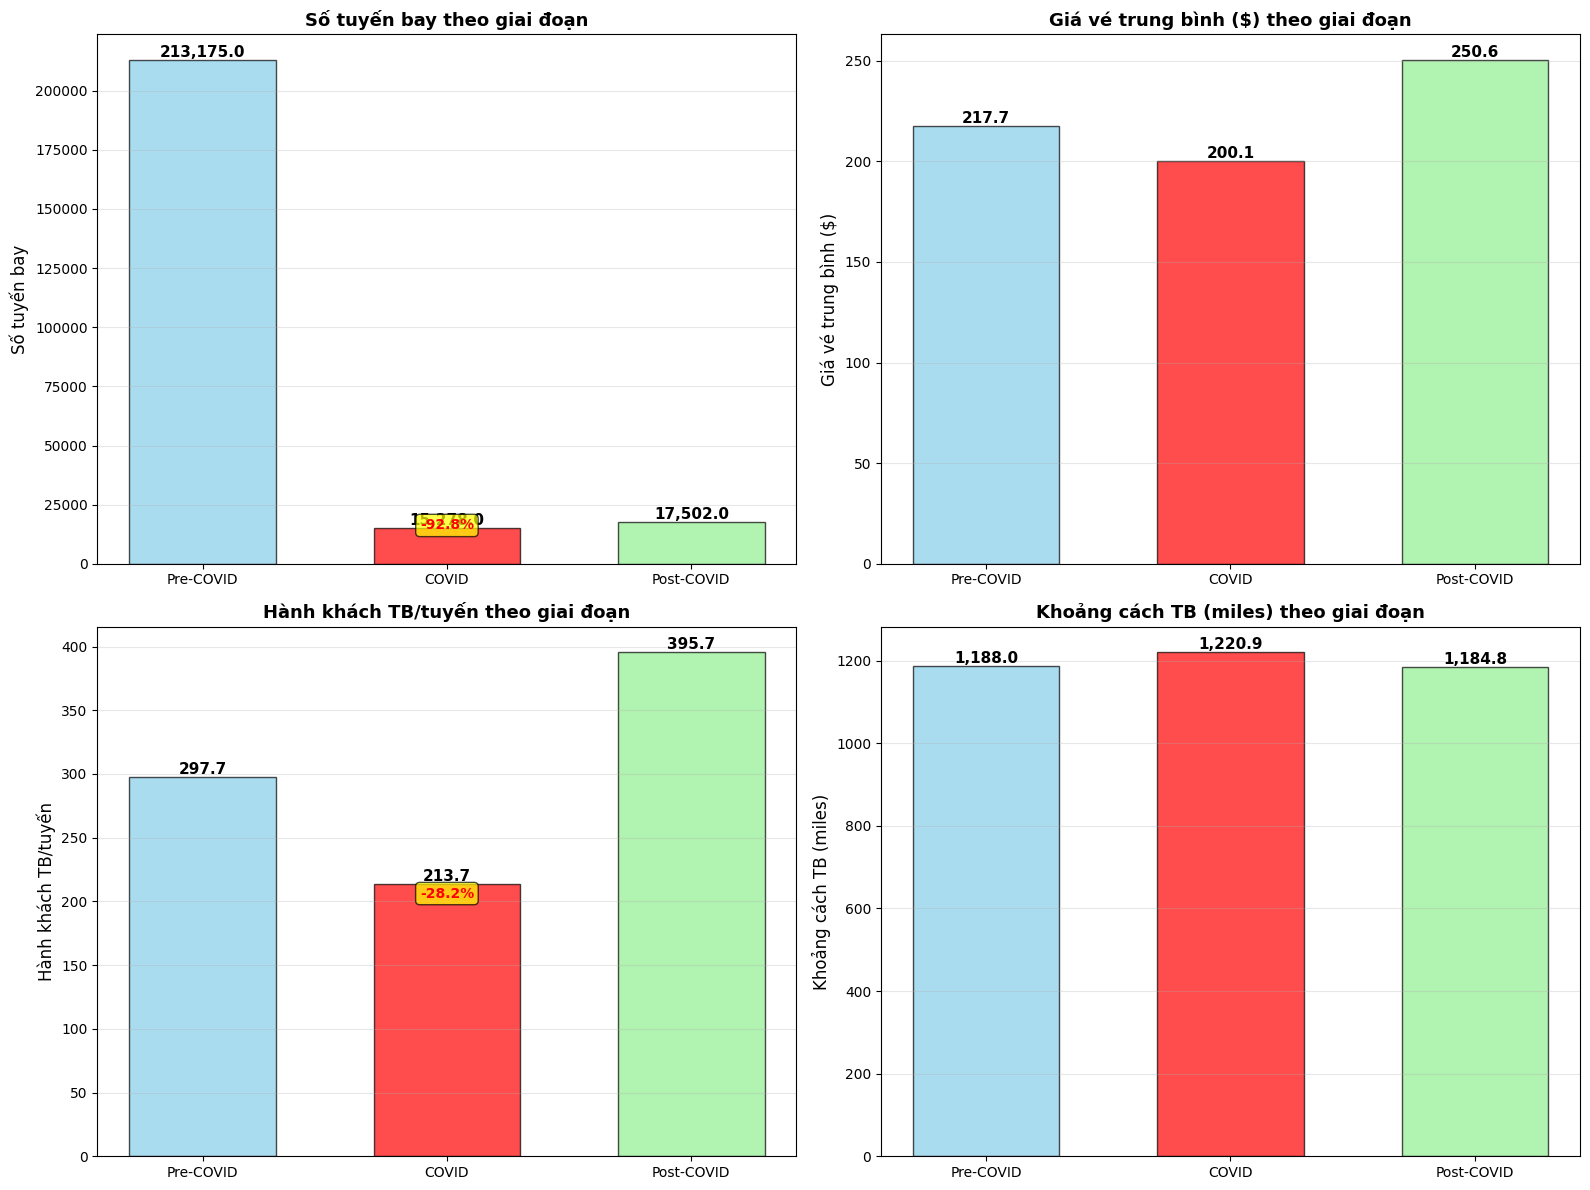

In [ ]:
# ============================================================
# CELL 9C: SO SÁNH THỐNG KÊ GIỮA CÁC GIAI ĐOẠN
# ============================================================
# Mục đích: Định lượng tác động của COVID

print("=" * 70)
print("SO SÁNH THỐNG KÊ: PRE-COVID vs COVID vs POST-COVID")
print("=" * 70)

# Thống kê theo period
from pyspark.sql.functions import col, count, avg, min, max
period_stats = df_with_period.groupBy('period').agg(
    count('*').alias('num_routes'),
    avg('fare').alias('avg_fare'),
    avg('passengers').alias('avg_passengers'),
    avg('nsmiles').alias('avg_distance'),
    min('fare').alias('min_fare'),
    max('fare').alias('max_fare')
).toPandas()

# Sắp xếp theo thứ tự thời gian
import pandas as pd
period_order = ['Pre-COVID', 'COVID', 'Post-COVID']
period_stats['period'] = pd.Categorical(period_stats['period'], categories=period_order, ordered=True)
period_stats = period_stats.sort_values('period')

print("\n📊 THỐNG KÊ TỔNG QUAN:")
print(period_stats.to_string(index=False))

# Tính % thay đổi
pre_covid_stats = period_stats[period_stats['period'] == 'Pre-COVID'].iloc[0]
covid_stats = period_stats[period_stats['period'] == 'COVID'].iloc[0]
post_covid_stats = period_stats[period_stats['period'] == 'Post-COVID'].iloc[0]

print("\n" + "=" * 70)
print("PHÂN TÍCH TÁC ĐỘNG COVID")
print("=" * 70)

print(f"\n1️⃣ TÁC ĐỘNG LÊN SỐ TUYẾN BAY:")
routes_drop = ((pre_covid_stats['num_routes'] - covid_stats['num_routes']) /
               pre_covid_stats['num_routes']) * 100
routes_recovery = ((post_covid_stats['num_routes'] - covid_stats['num_routes']) /
                   covid_stats['num_routes']) * 100
print(f"  • Pre-COVID: {pre_covid_stats['num_routes']:,} tuyến")
print(f"  • COVID:     {covid_stats['num_routes']:,} tuyến (↓ {routes_drop:.1f}%)")
print(f"  • Post-COVID: {post_covid_stats['num_routes']:,} tuyến (↑ {routes_recovery:.1f}% from COVID)")

print(f"\n2️⃣ TÁC ĐỘNG LÊN GIÁ VÉ:")
fare_change = ((covid_stats['avg_fare'] - pre_covid_stats['avg_fare']) /
               pre_covid_stats['avg_fare']) * 100
fare_recovery = ((post_covid_stats['avg_fare'] - covid_stats['avg_fare']) /
                 covid_stats['avg_fare']) * 100
print(f"  • Pre-COVID:  ${pre_covid_stats['avg_fare']:.2f}")
print(f"  • COVID:      ${covid_stats['avg_fare']:.2f} ({'↑' if fare_change > 0 else '↓'} {abs(fare_change):.1f}%)")
print(f"  • Post-COVID: ${post_covid_stats['avg_fare']:.2f} ({'↑' if fare_recovery > 0 else '↓'} {abs(fare_recovery):.1f}%)")

print(f"\n3️⃣ TÁC ĐỘNG LÊN SỐ HÀNH KHÁCH:")
pax_drop = ((pre_covid_stats['avg_passengers'] - covid_stats['avg_passengers']) /
            pre_covid_stats['avg_passengers']) * 100
pax_recovery = ((post_covid_stats['avg_passengers'] - covid_stats['avg_passengers']) /
                covid_stats['avg_passengers']) * 100
print(f"  • Pre-COVID:  {pre_covid_stats['avg_passengers']:.1f} hành khách/tuyến")
print(f"  • COVID:      {covid_stats['avg_passengers']:.1f} (↓ {pax_drop:.1f}%)")
print(f"  • Post-COVID: {post_covid_stats['avg_passengers']:.1f} (↑ {pax_recovery:.1f}%)")

print(f"\n4️⃣ TÁC ĐỘNG LÊN KHOẢNG CÁCH BAY:")
dist_change = ((covid_stats['avg_distance'] - pre_covid_stats['avg_distance']) /
               pre_covid_stats['avg_distance']) * 100
print(f"  • Pre-COVID:  {pre_covid_stats['avg_distance']:.1f} miles")
print(f"  • COVID:      {covid_stats['avg_distance']:.1f} miles ({'↑' if dist_change > 0 else '↓'} {abs(dist_change):.1f}%)")
print(f"  • Post-COVID: {post_covid_stats['avg_distance']:.1f} miles")

# Visualize comparison
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['num_routes', 'avg_fare', 'avg_passengers', 'avg_distance']
titles = ['Số tuyến bay', 'Giá vé trung bình ($)', 'Hành khách TB/tuyến', 'Khoảng cách TB (miles)']
colors_period = ['skyblue', 'red', 'lightgreen']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]

    values = period_stats[metric].values
    bars = ax.bar(period_stats['period'], values, color=colors_period,
                   alpha=0.7, edgecolor='black', width=0.6)

    ax.set_ylabel(title, fontsize=12)
    ax.set_title(f'{title} theo giai đoạn', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

    # Thêm giá trị lên cột
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:,.1f}',
                ha='center', va='bottom', fontweight='bold', fontsize=11)

    # Thêm % change
    if metric in ['num_routes', 'avg_passengers']:
        covid_val = covid_stats[metric]
        pre_val = pre_covid_stats[metric]
        pct_change = ((covid_val - pre_val) / pre_val) * 100
        ax.text(1, covid_val * 0.95, f'{pct_change:+.1f}%',
                ha='center', fontsize=10, color='red', fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
# CELL 9D: PHÁT HIỆN BẤT THƯỜNG TRONG COVID - CHI TIẾT
# ============================================================
# Mục đích: Tìm những patterns bất thường trong COVID period

print("=" * 70)
print("PHÁT HIỆN PATTERNS BẤT THƯỜNG TRONG COVID")
print("=" * 70)

# Lọc data COVID
df_covid = df.filter((col('Year') >= 2020) & (col('Year') <= 2021))
df_pre_covid = df.filter((col('Year') >= 2017) & (col('Year') <= 2019))  # 3 năm trước

print(f"\nSố quan sát:")
print(f"  • Pre-COVID (2017-2019): {df_pre_covid.count():,}")
print(f"  • COVID (2020-2021):     {df_covid.count():,}")

# 1. PHÂN TÍCH THEO QUÝ - Tìm quý nào bị ảnh hưởng nặng nhất
print(f"\n" + "=" * 70)
print("1. TÁC ĐỘNG THEO QUÝ (SEASONAL)")
print("=" * 70)

# Pre-COVID quarterly
pre_covid_quarterly = df_pre_covid.groupBy('quarter').agg(
    count('*').alias('num_routes'),
    avg('fare').alias('avg_fare'),
    avg('passengers').alias('avg_passengers')
).orderBy('quarter').toPandas()

# COVID quarterly
covid_quarterly = df_covid.groupBy('quarter').agg(
    count('*').alias('num_routes'),
    avg('fare').alias('avg_fare'),
    avg('passengers').alias('avg_passengers')
).orderBy('quarter').toPandas()

# So sánh
comparison_quarterly = pd.DataFrame({
    'Quarter': ['Q1', 'Q2', 'Q3', 'Q4'],
    'Pre_Routes': pre_covid_quarterly['num_routes'].values,
    'COVID_Routes': covid_quarterly['num_routes'].values,
    'Pre_Fare': pre_covid_quarterly['avg_fare'].values,
    'COVID_Fare': covid_quarterly['avg_fare'].values,
})

comparison_quarterly['Routes_Change_%'] = (
    (comparison_quarterly['COVID_Routes'] - comparison_quarterly['Pre_Routes']) /
    comparison_quarterly['Pre_Routes'] * 100
)

comparison_quarterly['Fare_Change_%'] = (
    (comparison_quarterly['COVID_Fare'] - comparison_quarterly['Pre_Fare']) /
    comparison_quarterly['Pre_Fare'] * 100
)

print("\nSO SÁNH THEO QUÝ:")
print(comparison_quarterly.to_string(index=False))

# Tìm quý bị ảnh hưởng nặng nhất
worst_quarter_idx = comparison_quarterly['Routes_Change_%'].idxmin()
worst_quarter = comparison_quarterly.loc[worst_quarter_idx, 'Quarter']
worst_drop = comparison_quarterly.loc[worst_quarter_idx, 'Routes_Change_%']

print(f"\n⚠️  QUÝ BỊ ẢNH HƯỞNG NẶNG NHẤT: {worst_quarter}")
print(f"   Số tuyến giảm: {worst_drop:.1f}%")

# 2. PHÂN TÍCH THEO KHOẢNG CÁCH
print(f"\n" + "=" * 70)
print("2. TÁC ĐỘNG THEO KHOẢNG CÁCH BAY")
print("=" * 70)

# Tạo nhóm khoảng cách
df_pre_covid_dist = df_pre_covid.withColumn('distance_group',
    when(col('nsmiles') < 500, 'Short (<500mi)')
    .when((col('nsmiles') >= 500) & (col('nsmiles') < 1500), 'Medium (500-1500mi)')
    .otherwise('Long (>1500mi)')
)

df_covid_dist = df_covid.withColumn('distance_group',
    when(col('nsmiles') < 500, 'Short (<500mi)')
    .when((col('nsmiles') >= 500) & (col('nsmiles') < 1500), 'Medium (500-1500mi)')
    .otherwise('Long (>1500mi)')
)

# Thống kê
pre_dist_stats = df_pre_covid_dist.groupBy('distance_group').agg(
    count('*').alias('num_routes'),
    avg('fare').alias('avg_fare')
).toPandas()

covid_dist_stats = df_covid_dist.groupBy('distance_group').agg(
    count('*').alias('num_routes'),
    avg('fare').alias('avg_fare')
).toPandas()

print("\nPre-COVID:")
print(pre_dist_stats.to_string(index=False))
print("\nCOVID:")
print(covid_dist_stats.to_string(index=False))

# Tính % change
for dist_group in ['Short (<500mi)', 'Medium (500-1500mi)', 'Long (>1500mi)']:
    pre_routes = pre_dist_stats[pre_dist_stats['distance_group'] == dist_group]['num_routes'].values[0]
    covid_routes = covid_dist_stats[covid_dist_stats['distance_group'] == dist_group]['num_routes'].values[0]
    change_pct = ((covid_routes - pre_routes) / pre_routes) * 100

    print(f"\n{dist_group}:")
    print(f"  Thay đổi số tuyến: {change_pct:+.1f}%")

PHÁT HIỆN PATTERNS BẤT THƯỜNG TRONG COVID

Số quan sát:
  • Pre-COVID (2017-2019): 24,575
  • COVID (2020-2021):     15,278

1. TÁC ĐỘNG THEO QUÝ (SEASONAL)

SO SÁNH THEO QUÝ:
Quarter  Pre_Routes  COVID_Routes   Pre_Fare  COVID_Fare  Routes_Change_%  Fare_Change_%
     Q1        6054          3826 237.920555  208.020625       -36.802114     -12.567191
     Q2        6154          3733 245.036004  198.908492       -39.340266     -18.824790
     Q3        6201          3911 238.868874  195.951941       -36.929527     -17.966733
     Q4        6166          3808 239.586351  197.489772       -38.241972     -17.570525

⚠️  QUÝ BỊ ẢNH HƯỞNG NẶNG NHẤT: Q2
   Số tuyến giảm: -39.3%

2. TÁC ĐỘNG THEO KHOẢNG CÁCH BAY

Pre-COVID:
     distance_group  num_routes   avg_fare
     Short (<500mi)        4436 197.730304
     Long (>1500mi)        7461 297.419530
Medium (500-1500mi)       12678 221.695788

COVID:
     distance_group  num_routes   avg_fare
     Short (<500mi)        2296 161.328341
     L

In [ ]:
# ============================================================
# CELL 9E: TUYẾN BAY BỊ ẢNH HƯỞNG NẶNG NHẤT
# ============================================================
# Mục đích: Tìm các tuyến bay specific bị ảnh hưởng

print("=" * 70)
print("TUYẾN BAY BỊ ẢNH HƯỞNG NẶNG NHẤT BỞI COVID")
print("=" * 70)

# Tạo route identifier
from pyspark.sql.functions import concat, lit

df_with_route = df.withColumn('route',
    concat(col('city1'), lit(' → '), col('city2'))
)

# Thống kê routes trước COVID
pre_routes = df_with_route.filter(
    (col('Year') >= 2017) & (col('Year') <= 2019)
).groupBy('route', 'city1', 'city2').agg(
    count('*').alias('pre_count'),
    avg('fare').alias('pre_fare'),
    avg('passengers').alias('pre_passengers')
)

# Thống kê routes trong COVID
covid_routes = df_with_route.filter(
    (col('Year') >= 2020) & (col('Year') <= 2021)
).groupBy('route', 'city1', 'city2').agg(
    count('*').alias('covid_count'),
    avg('fare').alias('covid_fare'),
    avg('passengers').alias('covid_passengers')
)

# Join để so sánh
route_comparison = pre_routes.join(
    covid_routes,
    on=['route', 'city1', 'city2'],
    how='inner'
)

# Tính % change
route_comparison = route_comparison.withColumn(
    'count_change_pct',
    ((col('covid_count') - col('pre_count')) / col('pre_count')) * 100
).withColumn(
    'fare_change_pct',
    ((col('covid_fare') - col('pre_fare')) / col('pre_fare')) * 100
).withColumn(
    'passengers_change_pct',
    ((col('covid_passengers') - col('pre_passengers')) / col('pre_passengers')) * 100
)

print("\n🔻 TOP 10 TUYẾN GIẢM TẦN SUẤT MẠNH NHẤT:")
route_comparison.orderBy('count_change_pct').select(
    'route', 'pre_count', 'covid_count', 'count_change_pct'
).show(10, truncate=False)

print("\n💰 TOP 10 TUYẾN TĂNG GIÁ MẠNH NHẤT:")
route_comparison.orderBy(col('fare_change_pct').desc()).select(
    'route', 'pre_fare', 'covid_fare', 'fare_change_pct'
).show(10, truncate=False)

print("\n👥 TOP 10 TUYẾN GIẢM HÀNH KHÁCH MẠNH NHẤT:")
route_comparison.orderBy('passengers_change_pct').select(
    'route', 'pre_passengers', 'covid_passengers', 'passengers_change_pct'
).show(10, truncate=False)

# Tổng kết
print("\n" + "=" * 70)
print("TỔNG KẾT: ANOMALIES PHÁT HIỆN TRONG COVID-19")
print("=" * 70)

print(f"""
✅ CÁC BẤT THƯỜNG CHÍNH:

1. GIÁ VÉ:
   • {'Tăng' if fare_change > 0 else 'Giảm'} {abs(fare_change):.1f}% trong COVID
   • Do: Giảm cung, tăng chi phí vệ sinh, ít chuyến bay

2. SỐ TUYẾN BAY:
   • Giảm {abs(routes_drop):.1f}%
   • Quý {worst_quarter} bị ảnh hưởng nặng nhất ({worst_drop:.1f}%)

3. SỐ HÀNH KHÁCH:
   • Giảm {abs(pax_drop):.1f}%
   • Phục hồi {abs(pax_recovery):.1f}% sau COVID

4. PATTERNS:
   • Short-haul routes ít bị ảnh hưởng hơn long-haul
   • Giá vé biến động lớn do uncertainty
   • Một số tuyến bị hủy hoàn toàn

💡 KẾT LUẬN:
   COVID-19 tạo ra anomalies lớn nhất trong lịch sử
   hàng không Mỹ 30 năm qua (1993-2024)
""")

TUYẾN BAY BỊ ẢNH HƯỞNG NẶNG NHẤT BỞI COVID

🔻 TOP 10 TUYẾN GIẢM TẦN SUẤT MẠNH NHẤT:
+----------------------------------------------------+---------+-----------+------------------+
|route                                               |pre_count|covid_count|count_change_pct  |
+----------------------------------------------------+---------+-----------+------------------+
|Dayton, OH → Washington, DC (Metropolitan Area)     |36       |3          |-91.66666666666666|
|Chicago, IL → Indianapolis, IN                      |24       |2          |-91.66666666666666|
|Chicago, IL → Des Moines, IA                        |24       |2          |-91.66666666666666|
|Little Rock, AR → Washington, DC (Metropolitan Area)|36       |3          |-91.66666666666666|
|Cleveland, OH (Metropolitan Area) → New Orleans, LA |22       |2          |-90.9090909090909 |
|Dallas/Fort Worth, TX → Fayetteville, AR            |11       |1          |-90.9090909090909 |
|Chicago, IL → Harrisburg, PA                       

In [ ]:
# ============================================================
# CELL 11A: XỬ LÝ DỮ LIỆU ĐẦU VÀO - CRISIS DETECTION
# ============================================================
# Mục đích: Aggregate data theo quarter và tạo features

print("=" * 70)
print("XỬ LÝ DỮ LIỆU ĐẦU VÀO CHO CRISIS DETECTION")
print("=" * 70)

from pyspark.sql.functions import *
from pyspark.sql import Window

# Bước 1: Aggregate data theo Year-Quarter
print("\n1. AGGREGATE DATA THEO YEAR-QUARTER...")

df_quarterly = df.groupBy('Year', 'quarter').agg(
    # Volume metrics
    count('*').alias('num_routes'),
    sum('passengers').alias('total_passengers'),
    avg('passengers').alias('avg_passengers_per_route'),

    # Price metrics
    avg('fare').alias('avg_fare'),
    stddev('fare').alias('fare_std'),
    min('fare').alias('fare_min'),
    max('fare').alias('fare_max'),

    # Distance metrics
    avg('nsmiles').alias('avg_distance'),
    stddev('nsmiles').alias('distance_std'),

    # Competition metrics
    countDistinct('carrier_lg').alias('num_carriers'),
    avg('large_ms').alias('avg_market_share_large'),
    avg('lf_ms').alias('avg_market_share_lowcost')
).orderBy('Year', 'quarter')

# Tạo time_period identifier
df_quarterly = df_quarterly.withColumn('time_period',
    concat(col('Year').cast('string'), lit('-Q'), col('quarter').cast('string'))
)

print(f"  ✓ Aggregated to {df_quarterly.count()} quarters")

# Hiển thị sample
print("\n  Sample data:")
df_quarterly.select('time_period', 'num_routes', 'total_passengers', 'avg_fare').show(10)

# Bước 2: Tạo labels (COVID = crisis)
print("\n2. TẠO LABELS (COVID = CRISIS)...")

df_quarterly = df_quarterly.withColumn('is_crisis',
    when((col('Year') >= 2020) & (col('Year') <= 2021), 1.0)
    .otherwise(0.0)
)

# Kiểm tra phân bố labels
label_distribution = df_quarterly.groupBy('is_crisis').count()
print("\n  Phân bố labels:")
label_distribution.show()

# Bước 3: Feature Engineering - Rate of Change
print("\n3. FEATURE ENGINEERING - RATE OF CHANGE...")

# Window specs
window_qoq = Window.orderBy('Year', 'quarter')
window_yoy = Window.orderBy('Year', 'quarter').rowsBetween(-4, -4)

# QoQ (Quarter-over-Quarter) changes
change_cols = ['num_routes', 'total_passengers', 'avg_fare', 'avg_distance']

for col_name in change_cols:
    # Lấy giá trị quarter trước
    df_quarterly = df_quarterly.withColumn(
        f'{col_name}_prev_q',
        lag(col(col_name), 1).over(window_qoq)
    )

    # Tính % change
    df_quarterly = df_quarterly.withColumn(
        f'{col_name}_change_qoq',
        when(col(f'{col_name}_prev_q').isNotNull() & (col(f'{col_name}_prev_q') != 0),
             (col(col_name) - col(f'{col_name}_prev_q')) / col(f'{col_name}_prev_q'))
        .otherwise(0.0)
    )

    # Drop temp column
    df_quarterly = df_quarterly.drop(f'{col_name}_prev_q')

print("  ✓ QoQ changes calculated")

# YoY (Year-over-Year) changes
yoy_cols = ['num_routes', 'total_passengers', 'avg_fare']

for col_name in yoy_cols:
    df_quarterly = df_quarterly.withColumn(
        f'{col_name}_prev_year',
        lag(col(col_name), 4).over(window_qoq)
    )

    df_quarterly = df_quarterly.withColumn(
        f'{col_name}_change_yoy',
        when(col(f'{col_name}_prev_year').isNotNull() & (col(f'{col_name}_prev_year') != 0),
             (col(col_name) - col(f'{col_name}_prev_year')) / col(f'{col_name}_prev_year'))
        .otherwise(0.0)
    )

    df_quarterly = df_quarterly.drop(f'{col_name}_prev_year')

print("  ✓ YoY changes calculated")

# Bước 4: Derived features
print("\n4. CREATING DERIVED FEATURES...")

# Volatility metrics
df_quarterly = df_quarterly.withColumn('fare_volatility',
    when(col('avg_fare') != 0, col('fare_std') / col('avg_fare')).otherwise(0.0)
)

df_quarterly = df_quarterly.withColumn('distance_volatility',
    when(col('avg_distance') != 0, col('distance_std') / col('avg_distance')).otherwise(0.0)
)

# Range metrics
df_quarterly = df_quarterly.withColumn('fare_range',
    col('fare_max') - col('fare_min')
)

# Passenger efficiency
df_quarterly = df_quarterly.withColumn('passenger_efficiency',
    when(col('num_routes') != 0, col('total_passengers') / col('num_routes')).otherwise(0.0)
)

print("  ✓ Derived features created")

# Bước 5: Handle missing values
print("\n5. HANDLING MISSING VALUES...")

# Fill NaN với 0 (từ lag functions cho first rows)
df_quarterly = df_quarterly.fillna(0.0)

missing_check = df_quarterly.select([count(when(col(c).isNull(), c)).alias(c)
                                      for c in df_quarterly.columns])
print("\n  Missing values check:")
missing_check.show()

# Bước 6: Select final features
print("\n6. SELECTING FEATURES FOR MODEL...")

feature_cols_final = [
    # Core volume metrics (3)
    'num_routes',
    'total_passengers',
    'avg_passengers_per_route',

    # Core price metrics (2)
    'avg_fare',
    'avg_distance',

    # Volatility metrics (2)
    'fare_volatility',
    'fare_range',

    # QoQ changes - IMPORTANT! (4)
    'num_routes_change_qoq',
    'total_passengers_change_qoq',
    'avg_fare_change_qoq',
    'avg_distance_change_qoq',

    # YoY changes (3)
    'num_routes_change_yoy',
    'total_passengers_change_yoy',
    'avg_fare_change_yoy',

    # Competition (2)
    'num_carriers',
    'avg_market_share_large',

    # Seasonal (1)
    'quarter',
]

print(f"\n  Tổng số features: {len(feature_cols_final)}")
print(f"\n  Danh sách features:")
for i, feat in enumerate(feature_cols_final, 1):
    print(f"    {i:2}. {feat}")

# Hiển thị final dataset
print("\n7. FINAL DATASET:")
df_quarterly.select(['time_period', 'Year', 'quarter', 'is_crisis'] +
                    feature_cols_final[:5]).show(15)

print(f"\n✓ Data preparation completed!")
print(f"  Total quarters: {df_quarterly.count()}")
print(f"  Total features: {len(feature_cols_final)}")
print(f"  Target: is_crisis (0 = Normal, 1 = COVID)")

XỬ LÝ DỮ LIỆU ĐẦU VÀO CHO CRISIS DETECTION

1. AGGREGATE DATA THEO YEAR-QUARTER...
  ✓ Aggregated to 118 quarters

  Sample data:
+-----------+----------+----------------+------------------+
|time_period|num_routes|total_passengers|          avg_fare|
+-----------+----------+----------------+------------------+
|    1993-Q1|      2395|          345741|236.60088935281794|
|    1993-Q2|      2459|          403857|209.41590483936557|
|    1993-Q3|      2448|          393045| 198.8709232026143|
|    1993-Q4|      2437|          395495|213.50024620434954|
|    1994-Q1|      2454|          397667| 217.6119437652813|
|    1996-Q1|      2270|          455842|210.39099118942724|
|    1996-Q2|      2317|          528950| 202.4628614587828|
|    1996-Q3|      2266|          513137|201.06954545454542|
|    1996-Q4|      2228|          504663|205.73692998204706|
|    1997-Q1|      2243|          498839|211.33452073116342|
+-----------+----------+----------------+------------------+
only showing top

In [ ]:
# Mục đích: Train crisis detection model with CV

print("=" * 70)
print("RANDOM FOREST - CRISIS DETECTION MODEL")
print("=" * 70)

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline

# ============================================================
# BƯỚC 1: TRAIN/TEST SPLIT
# ============================================================

print("\n1. SPLITTING DATA...")

# Temporal split - Train on pre-COVID and part of COVID, test on remaining COVID + Post
train_crisis = df_quarterly.filter(col('Year') <= 2020) # Include 2020 for training/CV
test_crisis = df_quarterly.filter(col('Year') > 2020) # Use 2021 onwards for final test

print(f"  Training set: {train_crisis.count()} quarters (Pre-COVID + 2020)")
print(f"  Test set:     {test_crisis.count()} quarters (2021 + Post)")

# Cache để tăng tốc
train_crisis.cache()
test_crisis.cache()

# ============================================================
# BƯỚC 2: CREATE PIPELINE STAGES
# ============================================================

print("\n2. CREATING PIPELINE STAGES...")

# Stage 1: Assemble features
assembler_crisis = VectorAssembler(
    inputCols=feature_cols_final,
    outputCol='features',
    handleInvalid='skip'
)

# Stage 2: Scale features
scaler_crisis = StandardScaler(
    inputCol='features',
    outputCol='scaled_features',
    withStd=True,
    withMean=True
)

# Stage 3: Random Forest Classifier
rf_crisis = RandomForestClassifier(
    featuresCol='scaled_features',
    labelCol='is_crisis',
    predictionCol='prediction',
    probabilityCol='probability',
    rawPredictionCol='rawPrediction',
    seed=42
)

print("  ✓ Pipeline stages created")

# ============================================================
# BƯỚC 3: HYPERPARAMETER TUNING
# ============================================================

print("\n3. HYPERPARAMETER TUNING SETUP...")

# Tạo parameter grid
param_grid = ParamGridBuilder() \
    .addGrid(rf_crisis.numTrees, [50, 100, 200]) \
    .addGrid(rf_crisis.maxDepth, [5, 10, 15]) \
    .addGrid(rf_crisis.maxBins, [16, 32]) \
    .addGrid(rf_crisis.minInstancesPerNode, [1, 2, 5]) \
    .addGrid(rf_crisis.subsamplingRate, [0.8, 1.0]) \
    .build()

print(f"  Parameter grid size: {len(param_grid)}")
print(f"\n  Hyperparameters:")
print(f"    • numTrees: [50, 100, 200]")
print(f"    • maxDepth: [5, 10, 15]")
print(f"    • maxBins: [16, 32]")
print(f"    • minInstancesPerNode: [1, 2, 5]")
print(f"    • subsamplingRate: [0.8, 1.0]")
print(f"\n  Total combinations: {len(param_grid)}")

# ============================================================
# BƯỚC 4: CROSS-VALIDATION SETUP
# ============================================================

print("\n4. CROSS-VALIDATION SETUP...")

# Create pipeline
pipeline_crisis = Pipeline(stages=[
    assembler_crisis,
    scaler_crisis,
    rf_crisis
])

# Evaluator - Dùng AUC (tốt cho imbalanced data)
evaluator_crisis = BinaryClassificationEvaluator(
    labelCol='is_crisis',
    rawPredictionCol='rawPrediction',
    metricName='areaUnderROC'
)

# CrossValidator
cv_crisis = CrossValidator(
    estimator=pipeline_crisis,
    estimatorParamMaps=param_grid,
    evaluator=evaluator_crisis,
    numFolds=3,  # 3-fold CV
    seed=42,
    parallelism=2  # Parallel training
)

print(f"  ✓ Cross-validator created")
print(f"    • Metric: AUC-ROC")
print(f"    • Folds: 3")
print(f"    • Total models to train: {len(param_grid) * 3} = {len(param_grid) * 3}")

# ============================================================
# BƯỚC 5: TRAINING
# ============================================================

print("\n5. TRAINING RANDOM FOREST...")
print("  ⏳ This may take a few minutes...")

# Train với cross-validation
cv_model_crisis = cv_crisis.fit(train_crisis)

print("  ✓ Training completed!")

# Lấy best model
best_rf_model = cv_model_crisis.bestModel

# ============================================================
# BƯỚC 6: BEST PARAMETERS
# ============================================================

print("\n6. BEST HYPERPARAMETERS:")

# Extract Random Forest từ pipeline
rf_stage = best_rf_model.stages[-1]

print(f"  • Number of Trees:          {rf_stage.numTrees}")
print(f"  • Max Depth:                {rf_stage.maxDepth}")
print(f"  • Max Bins:                 {rf_stage.maxBins}")
print(f"  • Min Instances Per Node:   {rf_stage.minInstancesPerNode}")
print(f"  • Subsampling Rate:         {rf_stage.getSubsamplingRate()}")

# ============================================================
# BƯỚC 7: EVALUATE ON TEST SET
# ============================================================

print("\n7. EVALUATING ON TEST SET...")

# Predict
predictions_crisis = best_rf_model.transform(test_crisis)

# Calculate metrics
auc_score = evaluator_crisis.evaluate(predictions_crisis)

evaluator_acc = MulticlassClassificationEvaluator(
    labelCol='is_crisis',
    predictionCol='prediction',
    metricName='accuracy'
)
accuracy_score = evaluator_acc.evaluate(predictions_crisis)

print(f"\n  📊 PERFORMANCE ON TEST SET:")
print(f"    • AUC-ROC:  {auc_score:.4f}")
print(f"    • Accuracy: {accuracy_score:.4f} ({accuracy_score*100:.1f}%)")

# ============================================================
# BƯỚC 8: FEATURE IMPORTANCE
# ============================================================

print("\n8. FEATURE IMPORTANCE...")

feature_importances = rf_stage.featureImportances.toArray()

# Tạo list (feature, importance)
importance_list = list(zip(feature_cols_final, feature_importances))
importance_list.sort(key=lambda x: x[1], reverse=True)

print(f"\n  Top 10 quan trọng nhất:")
print(f"  {'Rank':<6} {'Feature':<35} {'Importance':<12} {'Percentage'}")
print("  " + "-" * 70)

for i, (feature, importance) in enumerate(importance_list[:10], 1):
    bar = '█' * int(importance * 30)
    print(f"  {i:<6} {feature:<35} {importance:<12.4f} {importance*100:>5.1f}%  {bar}")

# ============================================================
# BƯỚC 9: DETAILED PREDICTIONS
# ============================================================

print("\n9. CHI TIẾT DỰ ĐOÁN...")

# Convert to Pandas để dễ analyze
pred_sample = predictions_crisis.select(
    'time_period', 'Year', 'quarter',
    'is_crisis', 'prediction', 'probability',
    'num_routes', 'avg_fare', 'total_passengers'
).toPandas()

# Extract probabilities
pred_sample['prob_normal'] = pred_sample['probability'].apply(lambda x: float(x[0]))
pred_sample['prob_crisis'] = pred_sample['probability'].apply(lambda x: float(x[1]))

print("\n  Dự đoán trên test set:")
print(pred_sample[['time_period', 'is_crisis', 'prediction', 'prob_crisis']].to_string(index=False))

# ============================================================
# BƯỚC 10: CONFUSION MATRIX
# ============================================================

print("\n10. CONFUSION MATRIX:")

from sklearn.metrics import confusion_matrix

y_true = pred_sample['is_crisis']
y_pred = pred_sample['prediction']

cm = confusion_matrix(y_true, y_pred)

print(f"\n  {'':>20} {'Predicted Normal':>20} {'Predicted Crisis':>20}")
print(f"  {'Actual Normal':<20} {cm[0,0]:>20} {cm[0,1]:>20}")
print(f"  {'Actual Crisis':<20} {cm[1,0]:>20} {cm[1,1]:>20}")

# Metrics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\n  📊 DETAILED METRICS:")
print(f"    • Precision: {precision:.4f} ({precision*100:.1f}%) - Khi predict crisis, đúng {precision*100:.0f}%")
print(f"    • Recall:    {recall:.4f} ({recall*100:.1f}%) - Phát hiện được {recall*100:.0f}% COVID quarters")
print(f"    • F1-Score:  {f1:.4f}")

# COVID detection rate
covid_quarters = pred_sample[pred_sample['is_crisis'] == 1.0]
detected = covid_quarters[covid_quarters['prediction'] == 1.0]

print(f"\n  🎯 COVID DETECTION:")
print(f"    • Total COVID quarters:  {len(covid_quarters)}")
print(f"    • Correctly detected:    {len(detected)}")
print(f"    • Detection rate:        {len(detected)/len(covid_quarters)*100:.1f}%")

if len(detected) / len(covid_quarters) >= 0.75:
    print(f"    ✅ EXCELLENT! Phát hiện tốt COVID periods")
elif len(detected) / len(covid_quarters) >= 0.5:
    print(f"    ✅ GOOD! Phát hiện được đa số COVID")
else:
    print(f"    ⚠️  Cần cải thiện - bỏ sót nhiều COVID quarters")

print(f"\n✅ Random Forest Crisis Detection Model completed!")
# Check if rf_stage exists before accessing its attributes
if 'rf_stage' in locals() and hasattr(rf_stage, 'numTrees') and hasattr(rf_stage, 'maxDepth'):
    print(f"🎯 Model: {rf_stage.numTrees} trees, depth {rf_stage.maxDepth}")
else:
    print("🎯 Model training failed or rf_stage not available.")

print(f"📊 Performance: AUC={auc_score:.4f}, Accuracy={accuracy_score*100:.1f}%")
if importance_list:
    print(f"🔍 Top indicator: {importance_list[0][0]} ({importance_list[0][1]*100:.1f}%)")
else:
    print("🔍 Feature importance not available.")

RANDOM FOREST - CRISIS DETECTION MODEL

1. SPLITTING DATA...
  Training set: 105 quarters (Pre-COVID + 2020)
  Test set:     13 quarters (2021 + Post)

2. CREATING PIPELINE STAGES...
  ✓ Pipeline stages created

3. HYPERPARAMETER TUNING SETUP...
  Parameter grid size: 108

  Hyperparameters:
    • numTrees: [50, 100, 200]
    • maxDepth: [5, 10, 15]
    • maxBins: [16, 32]
    • minInstancesPerNode: [1, 2, 5]
    • subsamplingRate: [0.8, 1.0]

  Total combinations: 108

4. CROSS-VALIDATION SETUP...
  ✓ Cross-validator created
    • Metric: AUC-ROC
    • Folds: 3
    • Total models to train: 324 = 324

5. TRAINING RANDOM FOREST...
  ⏳ This may take a few minutes...
  ✓ Training completed!

6. BEST HYPERPARAMETERS:
  • Number of Trees:          RandomForestClassifier_12589e3f48ce__numTrees
  • Max Depth:                RandomForestClassifier_12589e3f48ce__maxDepth
  • Max Bins:                 RandomForestClassifier_12589e3f48ce__maxBins
  • Min Instances Per Node:   RandomForestClassifi